In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [2]:
from utilities import *
from models import *

In [3]:
pin_file = "../Data/pin.csv"

pin = read_pin(pin_file)

In [4]:
filename = "../Data/rssi4.csv"
B1 = "0117C55D14E4"

data = read_data(filename, B1)

All beacons: ['0117C55D14E4']
Selecting 0117C55D14E4


In [5]:
data[scanners] = minMaxScaling(data[scanners])

In [6]:
data_grouped = data.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()

## Train Validation Test Split

In [7]:
train, validation, test = train_validation_test_split(data_grouped)

In [8]:
train.groupby("location")[scanners].count()

,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
location,,,,,,,,,,,,,,,,,
V1_11,37,46,38,48,49,47,41,49,45,31,38,52,51,19,18,19,43
V1_12,53,43,36,56,53,52,35,37,64,38,43,65,64,41,53,40,44
V1_13,39,55,37,50,31,44,48,48,67,11,31,50,48,50,51,13,41
V1_14,27,64,34,42,37,49,62,39,65,9,64,32,49,40,52,41,46
V1_20,61,58,56,53,56,53,45,44,47,25,40,51,67,11,38,19,41
V1_21,44,57,39,48,54,48,58,39,63,18,48,49,43,41,41,37,39
V1_22,45,45,38,46,41,64,67,24,64,24,66,43,36,7,53,51,32
V1_23,40,47,42,37,26,73,63,34,76,23,64,43,48,7,59,55,31
V1_24,16,37,39,34,30,47,47,31,64,15,56,33,42,16,36,51,17


In [9]:
validation.shape

(344, 19)

In [10]:
test.shape

(344, 19)

In [11]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

## Imputation
1. Forward fill
2. Fill NaN

In [12]:
train_imputed = train.set_index("location").groupby("location").ffill()
train_imputed.fillna(0, inplace=True)
train_imputed.reset_index(inplace=True)

In [13]:
validation_imputed = validation.set_index("location").groupby("location").ffill()
validation_imputed.fillna(0, inplace=True)
validation_imputed.reset_index(inplace=True)

In [14]:
test_imputed = test.set_index("location").groupby("location").ffill()
test_imputed.fillna(0, inplace=True)
test_imputed.reset_index(inplace=True)

## Change Location to Coordinates

In [15]:
train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

In [16]:
validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

In [17]:
test_imputed["X"] = test_imputed["location"].apply(lambda x: pin[x]["X"])
test_imputed["Y"] = test_imputed["location"].apply(lambda x: pin[x]["Y"])

## Model Training

In [18]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [19]:
model = MLP()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, X_validation, y_validation)

Train on 1030 samples, validate on 344 samples
Epoch 1/1000
1030/1030 [==============================] - 1s 805us/sample - loss: 240.8251 - mae: 13.6019 - mse: 240.6121 - val_loss: 179.8368 - val_mae: 11.4154 - val_mse: 179.1980
Epoch 2/1000
1030/1030 [==============================] - 0s 62us/sample - loss: 118.6095 - mae: 8.4966 - mse: 116.3818 - val_loss: 62.6088 - val_mae: 5.5273 - val_mse: 57.8489
Epoch 3/1000
1030/1030 [==============================] - 0s 54us/sample - loss: 41.4256 - mae: 4.4405 - mse: 33.7542 - val_loss: 34.9155 - val_mae: 4.0292 - val_mse: 25.0227
Epoch 4/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 30.1071 - mae: 3.6406 - mse: 20.2866 - val_loss: 28.9346 - val_mae: 3.4601 - val_mse: 19.6087
Epoch 5/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 24.4087 - mae: 3.0958 - mse: 14.4647 - val_loss: 23.5242 - val_mae: 2.9486 - val_mse: 14.0163
Epoch 6/1000
1030/1030 [==============================] - 0s 52us/sam

Epoch 48/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.4846 - mae: 1.0274 - mse: 1.8025 - val_loss: 13.4300 - val_mae: 0.9861 - val_mse: 1.9129
Epoch 49/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.4867 - mae: 1.0280 - mse: 1.7984 - val_loss: 13.0875 - val_mae: 1.0221 - val_mse: 2.0073
Epoch 50/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.4318 - mae: 1.0194 - mse: 1.7591 - val_loss: 13.0914 - val_mae: 1.0196 - val_mse: 2.0026
Epoch 51/1000
1030/1030 [==============================] - 0s 45us/sample - loss: 12.4295 - mae: 1.0073 - mse: 1.7432 - val_loss: 13.0471 - val_mae: 1.0018 - val_mse: 1.9343
Epoch 52/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 12.4262 - mae: 1.0159 - mse: 1.7462 - val_loss: 13.5537 - val_mae: 1.5119 - val_mse: 3.5822
Epoch 53/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.4366 - mae: 1.0253 - mse: 1.7943 - val_loss: 

1030/1030 [==============================] - 0s 130us/sample - loss: 12.1960 - mae: 0.9574 - mse: 1.5284 - val_loss: 13.1205 - val_mae: 1.4714 - val_mse: 3.4616
Epoch 96/1000
1030/1030 [==============================] - 0s 145us/sample - loss: 12.1792 - mae: 0.9447 - mse: 1.5158 - val_loss: 12.6572 - val_mae: 1.1302 - val_mse: 2.2326
Epoch 97/1000
1030/1030 [==============================] - 0s 79us/sample - loss: 12.1767 - mae: 0.9445 - mse: 1.5111 - val_loss: 13.0679 - val_mae: 1.4401 - val_mse: 3.1951
Epoch 98/1000
1030/1030 [==============================] - 0s 55us/sample - loss: 12.1978 - mae: 0.9593 - mse: 1.5530 - val_loss: 13.0328 - val_mae: 0.9125 - val_mse: 1.6634
Epoch 99/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 12.1485 - mae: 0.9240 - mse: 1.4412 - val_loss: 12.5879 - val_mae: 1.0190 - val_mse: 1.9430
Epoch 100/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.1769 - mae: 0.9467 - mse: 1.5040 - val_loss: 12.8280 - v

Epoch 142/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.0111 - mae: 0.8821 - mse: 1.3159 - val_loss: 12.7248 - val_mae: 0.9257 - val_mse: 1.6728
Epoch 143/1000
1030/1030 [==============================] - 0s 53us/sample - loss: 12.0434 - mae: 0.8984 - mse: 1.3552 - val_loss: 12.5067 - val_mae: 1.1016 - val_mse: 2.1521
Epoch 144/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.9918 - mae: 0.8781 - mse: 1.3136 - val_loss: 12.7810 - val_mae: 1.3313 - val_mse: 2.8838
Epoch 145/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.0191 - mae: 0.8891 - mse: 1.3484 - val_loss: 12.5983 - val_mae: 0.9396 - val_mse: 1.7265
Epoch 146/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.0395 - mae: 0.8907 - mse: 1.3474 - val_loss: 12.5194 - val_mae: 1.0213 - val_mse: 1.9326
Epoch 147/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.0111 - mae: 0.8789 - mse: 1.3161 - val_

Epoch 189/1000
1030/1030 [==============================] - 0s 50us/sample - loss: 11.8900 - mae: 0.8319 - mse: 1.1829 - val_loss: 12.8153 - val_mae: 1.3904 - val_mse: 3.0514
Epoch 190/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.9125 - mae: 0.8487 - mse: 1.2390 - val_loss: 12.5448 - val_mae: 1.1060 - val_mse: 2.1236
Epoch 191/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.9201 - mae: 0.8574 - mse: 1.2352 - val_loss: 12.4507 - val_mae: 1.0928 - val_mse: 2.1076
Epoch 192/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.8834 - mae: 0.8404 - mse: 1.1915 - val_loss: 12.4335 - val_mae: 1.1153 - val_mse: 2.1995
Epoch 193/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.8825 - mae: 0.8408 - mse: 1.1980 - val_loss: 12.5259 - val_mae: 0.8587 - val_mse: 1.5092
Epoch 194/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.8748 - mae: 0.8306 - mse: 1.1716 - val_

Epoch 236/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.8020 - mae: 0.8079 - mse: 1.1000 - val_loss: 12.3439 - val_mae: 1.0257 - val_mse: 1.9044
Epoch 237/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.8130 - mae: 0.8082 - mse: 1.1165 - val_loss: 12.7119 - val_mae: 0.7986 - val_mse: 1.3889
Epoch 238/1000
1030/1030 [==============================] - 0s 78us/sample - loss: 11.7877 - mae: 0.7991 - mse: 1.0721 - val_loss: 12.8272 - val_mae: 0.8182 - val_mse: 1.4150
Epoch 239/1000
1030/1030 [==============================] - 0s 69us/sample - loss: 11.8140 - mae: 0.8032 - mse: 1.1024 - val_loss: 12.3533 - val_mae: 1.0337 - val_mse: 1.9543
Epoch 240/1000
1030/1030 [==============================] - 0s 78us/sample - loss: 11.8204 - mae: 0.8092 - mse: 1.1268 - val_loss: 12.4697 - val_mae: 1.1912 - val_mse: 2.3351
Epoch 241/1000
1030/1030 [==============================] - 0s 80us/sample - loss: 11.7911 - mae: 0.8108 - mse: 1.1138 - val_

Epoch 283/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.7294 - mae: 0.7824 - mse: 1.0332 - val_loss: 12.7962 - val_mae: 1.2911 - val_mse: 2.6514
Epoch 284/1000
1030/1030 [==============================] - 0s 52us/sample - loss: 11.7542 - mae: 0.7970 - mse: 1.0659 - val_loss: 12.4533 - val_mae: 1.1938 - val_mse: 2.3931
Epoch 285/1000
1030/1030 [==============================] - 0s 71us/sample - loss: 11.7263 - mae: 0.7868 - mse: 1.0425 - val_loss: 12.2527 - val_mae: 0.9486 - val_mse: 1.7014
Epoch 286/1000
1030/1030 [==============================] - 0s 77us/sample - loss: 11.7177 - mae: 0.7696 - mse: 1.0179 - val_loss: 12.4336 - val_mae: 1.1135 - val_mse: 2.1070
Epoch 287/1000
1030/1030 [==============================] - 0s 76us/sample - loss: 11.7459 - mae: 0.7895 - mse: 1.0556 - val_loss: 12.4146 - val_mae: 0.8566 - val_mse: 1.4846
Epoch 288/1000
1030/1030 [==============================] - 0s 59us/sample - loss: 11.7270 - mae: 0.7794 - mse: 1.0227 - val_

Epoch 330/1000
1030/1030 [==============================] - 0s 74us/sample - loss: 11.6796 - mae: 0.7544 - mse: 0.9751 - val_loss: 13.5558 - val_mae: 0.8572 - val_mse: 1.5634
Epoch 331/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.6850 - mae: 0.7488 - mse: 0.9463 - val_loss: 12.3275 - val_mae: 0.8184 - val_mse: 1.4209
Epoch 332/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.6470 - mae: 0.7495 - mse: 0.9414 - val_loss: 12.8892 - val_mae: 0.7569 - val_mse: 1.3298
Epoch 333/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.6626 - mae: 0.7563 - mse: 0.9493 - val_loss: 12.3963 - val_mae: 0.8819 - val_mse: 1.5497
Epoch 334/1000
1030/1030 [==============================] - 0s 67us/sample - loss: 11.6793 - mae: 0.7658 - mse: 0.9829 - val_loss: 12.2969 - val_mae: 0.9630 - val_mse: 1.7443
Epoch 335/1000
1030/1030 [==============================] - 0s 86us/sample - loss: 11.6459 - mae: 0.7540 - mse: 0.9479 - val_

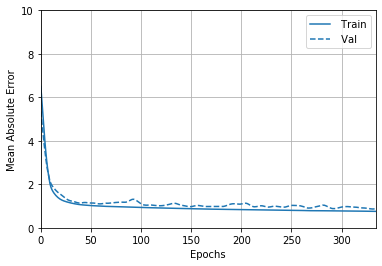

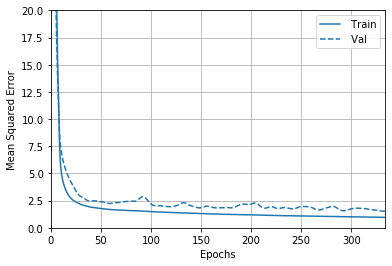

In [21]:
model.show_history()

## Model Validation

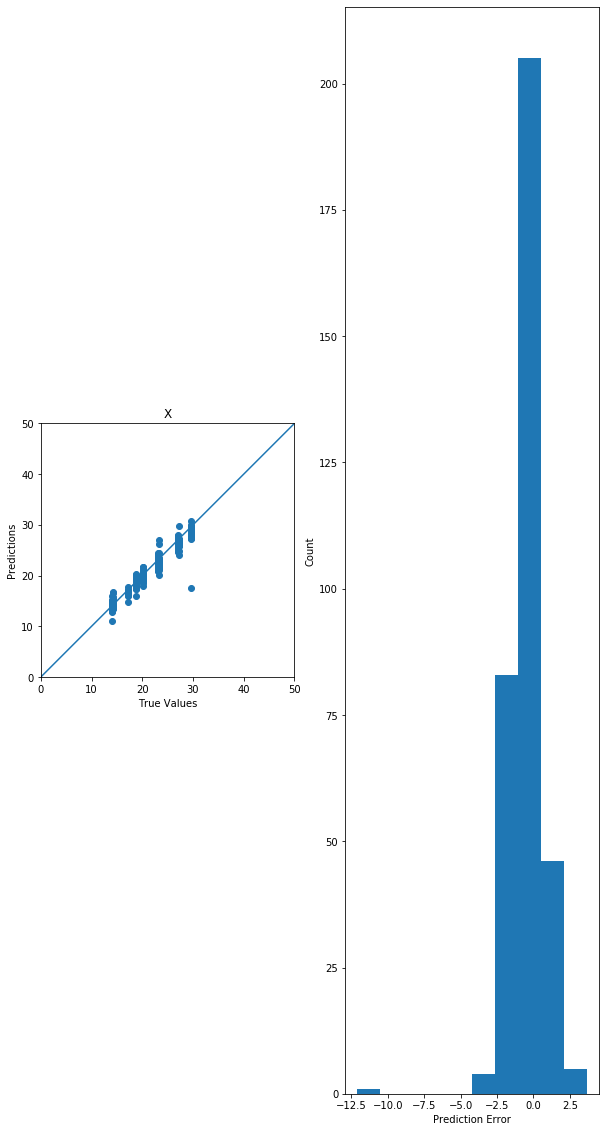

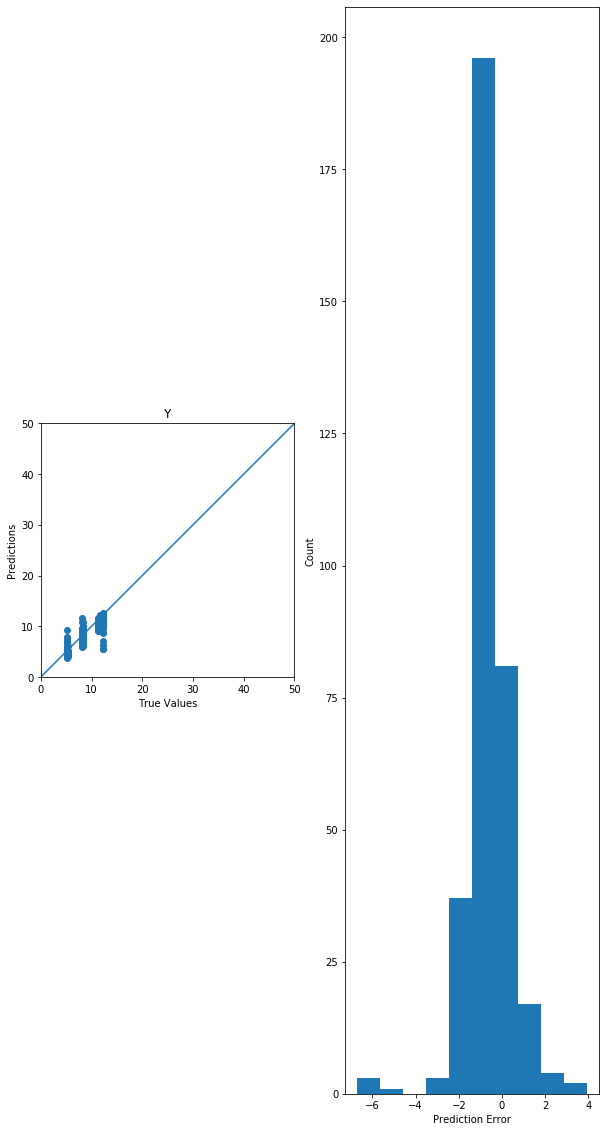

In [22]:
model.model_validation(X_validation, y_validation)

## Model Testing

In [23]:
model.model_testing(X_test, y_test)

344/1 - 0s - loss: 10.0686 - mae: 0.8977 - mse: 1.3056
Test loss: 12.359145308649817
Mean absolute error: 0.897748
Mean squared error: 1.3055953


## Plotting Learning Curves

In [24]:
train_loss = []
val_loss = []

for f in range(1, 11, 1):
    frac = f / 10.0
    sample = data_grouped.sample(frac=frac, random_state=12345)
    sample_grouped = sample.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()
    train, validation, test = train_validation_test_split(sample_grouped)

    train.sort_values("time", inplace=True)
    validation.sort_values("time", inplace=True)
    test.sort_values("time", inplace=True)

    train_imputed = train.set_index("location").groupby("location").ffill()
    train_imputed.fillna(0, inplace=True)
    train_imputed.reset_index(inplace=True)

    validation_imputed = validation.set_index("location").groupby("location").ffill()
    validation_imputed.fillna(0, inplace=True)
    validation_imputed.reset_index(inplace=True)

    test_imputed = test.set_index("location").groupby("location").ffill()
    test_imputed.fillna(0, inplace=True)
    test_imputed.reset_index(inplace=True)

    train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
    train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

    validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
    validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

    test_imputed["X"] = test_imputed["location"].apply(lambda x: pin[x]["X"])
    test_imputed["Y"] = test_imputed["location"].apply(lambda x: pin[x]["Y"])

    X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
    X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
    X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

    model = MLP()
    history = model.fit(X_train, y_train, X_validation, y_validation)
    train_loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 5,442
Trainable params: 5,442
Non-trainable params: 0
_________________________________________________________________
Train on 103 samples, validate on 34 samples
Epoch 1/1000
103/103 [==============================] - 1s 5ms/sample - loss: 272.3223 - mae: 14.7706 - mse: 272.2346 - val_loss: 270.8146 - val_mae: 14.8405 - val_mse: 270.7154
Epoch 2/1000
103/103 [==============================] - 0s 156us/sample - loss: 258.6066 - mae: 14.4313 - mse: 258.4957 - val_loss: 259.1663 - val_mae: 14.5283

Epoch 43/1000
103/103 [==============================] - 0s 234us/sample - loss: 19.0852 - mae: 2.4565 - mse: 8.9565 - val_loss: 23.5329 - val_mae: 2.9573 - val_mse: 14.9538
Epoch 44/1000
103/103 [==============================] - 0s 290us/sample - loss: 19.0089 - mae: 2.4632 - mse: 9.5699 - val_loss: 22.4300 - val_mae: 2.8561 - val_mse: 13.4495
Epoch 45/1000
103/103 [==============================] - 0s 230us/sample - loss: 18.6442 - mae: 2.4145 - mse: 8.8448 - val_loss: 22.5643 - val_mae: 2.8637 - val_mse: 13.8131
Epoch 46/1000
103/103 [==============================] - 0s 257us/sample - loss: 18.4729 - mae: 2.3892 - mse: 8.8698 - val_loss: 21.2800 - val_mae: 2.7218 - val_mse: 11.9726
Epoch 47/1000
103/103 [==============================] - 0s 253us/sample - loss: 18.0895 - mae: 2.3286 - mse: 8.1721 - val_loss: 21.1238 - val_mae: 2.6937 - val_mse: 11.9607
Epoch 48/1000
103/103 [==============================] - 0s 266us/sample - loss: 17.8930 - mae: 2.3084 - mse: 8.1473 - val_loss: 2

103/103 [==============================] - 0s 318us/sample - loss: 14.9918 - mae: 1.7689 - mse: 4.9437 - val_loss: 17.4971 - val_mae: 2.0585 - val_mse: 7.1663
Epoch 91/1000
103/103 [==============================] - 0s 241us/sample - loss: 15.0140 - mae: 1.7342 - mse: 4.8091 - val_loss: 17.7306 - val_mae: 2.1825 - val_mse: 8.0310
Epoch 92/1000
103/103 [==============================] - 0s 262us/sample - loss: 14.9548 - mae: 1.7590 - mse: 4.9470 - val_loss: 17.3129 - val_mae: 2.0208 - val_mse: 6.7383
Epoch 93/1000
103/103 [==============================] - 0s 162us/sample - loss: 14.9906 - mae: 1.7270 - mse: 4.7110 - val_loss: 17.2679 - val_mae: 2.0890 - val_mse: 7.1676
Epoch 94/1000
103/103 [==============================] - 0s 179us/sample - loss: 15.0109 - mae: 1.7372 - mse: 4.7725 - val_loss: 17.3170 - val_mae: 2.0233 - val_mse: 6.8075
Epoch 95/1000
103/103 [==============================] - 0s 197us/sample - loss: 14.8077 - mae: 1.6653 - mse: 4.3702 - val_loss: 17.7798 - val_mae: 2

103/103 [==============================] - 0s 237us/sample - loss: 13.8461 - mae: 1.5082 - mse: 3.4630 - val_loss: 16.4609 - val_mae: 1.8584 - val_mse: 5.7328
Epoch 138/1000
103/103 [==============================] - 0s 211us/sample - loss: 13.6701 - mae: 1.4355 - mse: 3.2299 - val_loss: 16.5257 - val_mae: 1.8664 - val_mse: 5.9155
Epoch 139/1000
103/103 [==============================] - 0s 192us/sample - loss: 13.6020 - mae: 1.4397 - mse: 3.3249 - val_loss: 16.5831 - val_mae: 1.8607 - val_mse: 5.7264
Epoch 140/1000
103/103 [==============================] - 0s 238us/sample - loss: 13.5765 - mae: 1.4122 - mse: 3.1596 - val_loss: 16.4095 - val_mae: 1.8430 - val_mse: 5.7233
Epoch 141/1000
103/103 [==============================] - 0s 190us/sample - loss: 13.5626 - mae: 1.4324 - mse: 3.2326 - val_loss: 16.4440 - val_mae: 1.8380 - val_mse: 5.5738
Epoch 142/1000
103/103 [==============================] - 0s 213us/sample - loss: 13.5412 - mae: 1.4131 - mse: 3.1121 - val_loss: 16.4683 - val_m

103/103 [==============================] - 0s 184us/sample - loss: 12.7130 - mae: 1.2109 - mse: 2.4791 - val_loss: 16.2445 - val_mae: 1.9131 - val_mse: 6.1183
Epoch 185/1000
103/103 [==============================] - 0s 218us/sample - loss: 12.7329 - mae: 1.2375 - mse: 2.5636 - val_loss: 16.0702 - val_mae: 1.8811 - val_mse: 5.9170
Epoch 186/1000
103/103 [==============================] - 0s 192us/sample - loss: 12.6893 - mae: 1.2455 - mse: 2.5099 - val_loss: 16.0128 - val_mae: 1.8386 - val_mse: 5.6068
Epoch 187/1000
103/103 [==============================] - 0s 182us/sample - loss: 12.6613 - mae: 1.2091 - mse: 2.4317 - val_loss: 16.0996 - val_mae: 1.7457 - val_mse: 5.0821
Epoch 188/1000
103/103 [==============================] - 0s 156us/sample - loss: 12.6671 - mae: 1.1437 - mse: 2.2165 - val_loss: 16.1532 - val_mae: 1.8849 - val_mse: 5.8802
Epoch 189/1000
103/103 [==============================] - 0s 238us/sample - loss: 12.6319 - mae: 1.1765 - mse: 2.3378 - val_loss: 16.2449 - val_m

Epoch 231/1000
103/103 [==============================] - 0s 340us/sample - loss: 12.4918 - mae: 1.1145 - mse: 1.9957 - val_loss: 15.9845 - val_mae: 1.7461 - val_mse: 5.0469
Epoch 232/1000
103/103 [==============================] - 0s 425us/sample - loss: 12.3644 - mae: 1.1053 - mse: 1.9739 - val_loss: 15.9175 - val_mae: 1.7349 - val_mse: 5.0835
Epoch 233/1000
103/103 [==============================] - 0s 339us/sample - loss: 12.3754 - mae: 1.0873 - mse: 1.9742 - val_loss: 16.2966 - val_mae: 1.7230 - val_mse: 4.9120
Epoch 234/1000
103/103 [==============================] - 0s 400us/sample - loss: 12.3361 - mae: 1.0231 - mse: 1.7824 - val_loss: 16.1255 - val_mae: 1.9136 - val_mse: 6.0430
Epoch 235/1000
103/103 [==============================] - 0s 468us/sample - loss: 12.4208 - mae: 1.2011 - mse: 2.3254 - val_loss: 16.1402 - val_mae: 1.7785 - val_mse: 5.1572
Epoch 236/1000
103/103 [==============================] - 0s 486us/sample - loss: 12.3243 - mae: 1.0782 - mse: 1.9795 - val_loss: 

103/103 [==============================] - 0s 220us/sample - loss: 12.3174 - mae: 1.1541 - mse: 2.1588 - val_loss: 16.0378 - val_mae: 1.7391 - val_mse: 4.9526
Epoch 279/1000
103/103 [==============================] - 0s 208us/sample - loss: 12.1724 - mae: 1.0293 - mse: 1.7665 - val_loss: 16.3191 - val_mae: 1.7237 - val_mse: 4.8533
Epoch 280/1000
103/103 [==============================] - 0s 201us/sample - loss: 12.2100 - mae: 1.0024 - mse: 1.6318 - val_loss: 15.9738 - val_mae: 1.7966 - val_mse: 5.2992
Epoch 281/1000
103/103 [==============================] - 0s 177us/sample - loss: 12.2892 - mae: 1.0986 - mse: 2.0084 - val_loss: 16.5829 - val_mae: 1.7512 - val_mse: 4.9123
Epoch 282/1000
103/103 [==============================] - 0s 180us/sample - loss: 12.4022 - mae: 1.0239 - mse: 1.7427 - val_loss: 16.0284 - val_mae: 1.7237 - val_mse: 4.9129
Epoch 283/1000
103/103 [==============================] - 0s 228us/sample - loss: 12.1667 - mae: 1.0244 - mse: 1.7554 - val_loss: 17.2310 - val_m

206/206 [==============================] - 0s 114us/sample - loss: 22.8414 - mae: 2.9227 - mse: 12.8287 - val_loss: 22.8546 - val_mae: 2.8338 - val_mse: 13.0278
Epoch 22/1000
206/206 [==============================] - 0s 103us/sample - loss: 21.6216 - mae: 2.7779 - mse: 11.5360 - val_loss: 22.0097 - val_mae: 2.7794 - val_mse: 12.4484
Epoch 23/1000
206/206 [==============================] - 0s 120us/sample - loss: 20.4318 - mae: 2.6304 - mse: 10.3238 - val_loss: 20.6232 - val_mae: 2.5919 - val_mse: 10.6666
Epoch 24/1000
206/206 [==============================] - 0s 141us/sample - loss: 19.4742 - mae: 2.4931 - mse: 9.1314 - val_loss: 21.2986 - val_mae: 2.7597 - val_mse: 12.2802
Epoch 25/1000
206/206 [==============================] - 0s 133us/sample - loss: 18.9161 - mae: 2.4393 - mse: 8.8660 - val_loss: 19.1664 - val_mae: 2.4164 - val_mse: 9.1785
Epoch 26/1000
206/206 [==============================] - 0s 98us/sample - loss: 18.0551 - mae: 2.2878 - mse: 7.6738 - val_loss: 19.2583 - val_

206/206 [==============================] - 0s 112us/sample - loss: 13.5931 - mae: 1.3907 - mse: 2.9212 - val_loss: 15.5535 - val_mae: 1.7317 - val_mse: 4.8958
Epoch 69/1000
206/206 [==============================] - 0s 118us/sample - loss: 13.7234 - mae: 1.4192 - mse: 3.1354 - val_loss: 15.1992 - val_mae: 1.6279 - val_mse: 4.3385
Epoch 70/1000
206/206 [==============================] - 0s 82us/sample - loss: 13.5903 - mae: 1.3755 - mse: 2.8844 - val_loss: 15.9072 - val_mae: 1.9730 - val_mse: 5.9317
Epoch 71/1000
206/206 [==============================] - 0s 85us/sample - loss: 13.5303 - mae: 1.3776 - mse: 3.0133 - val_loss: 15.1888 - val_mae: 1.5985 - val_mse: 4.2162
Epoch 72/1000
206/206 [==============================] - 0s 88us/sample - loss: 13.4930 - mae: 1.3568 - mse: 2.8106 - val_loss: 15.4314 - val_mae: 1.7910 - val_mse: 5.0408
Epoch 73/1000
206/206 [==============================] - 0s 93us/sample - loss: 13.7213 - mae: 1.4027 - mse: 3.1038 - val_loss: 15.2514 - val_mae: 1.710

206/206 [==============================] - 0s 95us/sample - loss: 12.9683 - mae: 1.1862 - mse: 2.2959 - val_loss: 14.9002 - val_mae: 1.3483 - val_mse: 2.9848
Epoch 116/1000
206/206 [==============================] - 0s 97us/sample - loss: 12.8234 - mae: 1.0936 - mse: 1.9794 - val_loss: 14.6861 - val_mae: 1.5322 - val_mse: 3.7397
Epoch 117/1000
206/206 [==============================] - 0s 83us/sample - loss: 12.8700 - mae: 1.1309 - mse: 2.1375 - val_loss: 14.6126 - val_mae: 1.5482 - val_mse: 3.7922
Epoch 118/1000
206/206 [==============================] - 0s 93us/sample - loss: 12.8155 - mae: 1.1381 - mse: 2.1539 - val_loss: 14.8697 - val_mae: 1.5574 - val_mse: 3.8735
Epoch 119/1000
206/206 [==============================] - 0s 109us/sample - loss: 12.8249 - mae: 1.1289 - mse: 2.1159 - val_loss: 14.5797 - val_mae: 1.4914 - val_mse: 3.5518
Epoch 120/1000
206/206 [==============================] - 0s 104us/sample - loss: 12.8950 - mae: 1.1405 - mse: 2.1834 - val_loss: 14.8249 - val_mae: 

206/206 [==============================] - 0s 87us/sample - loss: 12.8491 - mae: 1.1364 - mse: 2.0975 - val_loss: 14.6833 - val_mae: 1.6161 - val_mse: 4.1031
Epoch 163/1000
206/206 [==============================] - 0s 93us/sample - loss: 12.5808 - mae: 1.0575 - mse: 1.9301 - val_loss: 14.4629 - val_mae: 1.4415 - val_mse: 3.3164
Epoch 164/1000
206/206 [==============================] - 0s 99us/sample - loss: 12.5447 - mae: 1.0335 - mse: 1.8016 - val_loss: 14.8094 - val_mae: 1.6966 - val_mse: 4.3870
Epoch 165/1000
206/206 [==============================] - 0s 84us/sample - loss: 12.6949 - mae: 1.1025 - mse: 2.0288 - val_loss: 14.8946 - val_mae: 1.6848 - val_mse: 4.4402
Epoch 166/1000
206/206 [==============================] - 0s 101us/sample - loss: 12.5633 - mae: 1.0605 - mse: 1.9322 - val_loss: 14.4374 - val_mae: 1.3957 - val_mse: 3.1337
Epoch 167/1000
206/206 [==============================] - 0s 87us/sample - loss: 12.6315 - mae: 1.0537 - mse: 1.8693 - val_loss: 14.4907 - val_mae: 1

206/206 [==============================] - 0s 71us/sample - loss: 12.4384 - mae: 1.0013 - mse: 1.6909 - val_loss: 14.6383 - val_mae: 1.6012 - val_mse: 3.9441
Epoch 210/1000
206/206 [==============================] - 0s 70us/sample - loss: 12.4748 - mae: 1.0222 - mse: 1.7674 - val_loss: 14.5120 - val_mae: 1.3289 - val_mse: 2.9204
Epoch 211/1000
206/206 [==============================] - 0s 70us/sample - loss: 12.5498 - mae: 1.0215 - mse: 1.7703 - val_loss: 14.6193 - val_mae: 1.6081 - val_mse: 3.9378
Epoch 212/1000
206/206 [==============================] - 0s 69us/sample - loss: 12.4282 - mae: 1.0017 - mse: 1.7361 - val_loss: 14.4985 - val_mae: 1.3210 - val_mse: 2.8901
Epoch 213/1000
206/206 [==============================] - 0s 70us/sample - loss: 12.4032 - mae: 0.9801 - mse: 1.6312 - val_loss: 14.6788 - val_mae: 1.3657 - val_mse: 3.0619
Epoch 214/1000
206/206 [==============================] - 0s 76us/sample - loss: 12.4245 - mae: 0.9814 - mse: 1.6256 - val_loss: 14.4743 - val_mae: 1.

206/206 [==============================] - 0s 79us/sample - loss: 12.3554 - mae: 0.9783 - mse: 1.6107 - val_loss: 14.6829 - val_mae: 1.2978 - val_mse: 2.8668
Epoch 257/1000
206/206 [==============================] - 0s 93us/sample - loss: 12.4358 - mae: 0.9700 - mse: 1.6140 - val_loss: 14.5016 - val_mae: 1.4818 - val_mse: 3.4743
Epoch 258/1000
206/206 [==============================] - 0s 72us/sample - loss: 12.3375 - mae: 0.9637 - mse: 1.6124 - val_loss: 14.4787 - val_mae: 1.3880 - val_mse: 3.1252
Epoch 259/1000
206/206 [==============================] - 0s 72us/sample - loss: 12.3009 - mae: 0.9315 - mse: 1.4882 - val_loss: 15.0685 - val_mae: 1.8101 - val_mse: 4.8247
Epoch 260/1000
206/206 [==============================] - 0s 71us/sample - loss: 12.3801 - mae: 1.0218 - mse: 1.7464 - val_loss: 14.5301 - val_mae: 1.4287 - val_mse: 3.2682
Epoch 261/1000
206/206 [==============================] - 0s 72us/sample - loss: 12.2868 - mae: 0.9328 - mse: 1.5033 - val_loss: 14.8654 - val_mae: 1.

Epoch 17/1000
309/309 [==============================] - 0s 92us/sample - loss: 19.2277 - mae: 2.4403 - mse: 9.1993 - val_loss: 20.8279 - val_mae: 2.6129 - val_mse: 10.7477
Epoch 18/1000
309/309 [==============================] - 0s 93us/sample - loss: 18.3451 - mae: 2.3271 - mse: 8.2984 - val_loss: 19.7540 - val_mae: 2.4465 - val_mse: 9.4466
Epoch 19/1000
309/309 [==============================] - 0s 85us/sample - loss: 17.7173 - mae: 2.2270 - mse: 7.5815 - val_loss: 19.6064 - val_mae: 2.4647 - val_mse: 9.6622
Epoch 20/1000
309/309 [==============================] - 0s 78us/sample - loss: 17.3268 - mae: 2.1534 - mse: 7.2397 - val_loss: 18.9047 - val_mae: 2.3404 - val_mse: 8.6855
Epoch 21/1000
309/309 [==============================] - 0s 94us/sample - loss: 17.0479 - mae: 2.1187 - mse: 6.9224 - val_loss: 18.3388 - val_mae: 2.2183 - val_mse: 7.7796
Epoch 22/1000
309/309 [==============================] - 0s 82us/sample - loss: 16.8323 - mae: 2.0762 - mse: 6.6623 - val_loss: 18.0847 - v

309/309 [==============================] - 0s 76us/sample - loss: 12.9894 - mae: 1.2659 - mse: 2.6152 - val_loss: 15.1309 - val_mae: 1.6395 - val_mse: 4.1662
Epoch 65/1000
309/309 [==============================] - 0s 93us/sample - loss: 12.9831 - mae: 1.2495 - mse: 2.5993 - val_loss: 15.0498 - val_mae: 1.6052 - val_mse: 3.9174
Epoch 66/1000
309/309 [==============================] - 0s 68us/sample - loss: 12.9334 - mae: 1.2290 - mse: 2.5037 - val_loss: 15.2418 - val_mae: 1.7165 - val_mse: 4.5146
Epoch 67/1000
309/309 [==============================] - 0s 75us/sample - loss: 13.0143 - mae: 1.2711 - mse: 2.6155 - val_loss: 15.0074 - val_mae: 1.5754 - val_mse: 3.8150
Epoch 68/1000
309/309 [==============================] - 0s 83us/sample - loss: 12.8796 - mae: 1.2183 - mse: 2.4480 - val_loss: 15.3300 - val_mae: 1.7541 - val_mse: 4.6381
Epoch 69/1000
309/309 [==============================] - 0s 78us/sample - loss: 12.9424 - mae: 1.2378 - mse: 2.5227 - val_loss: 15.5780 - val_mae: 1.8474 

Epoch 112/1000
309/309 [==============================] - 0s 70us/sample - loss: 12.3613 - mae: 1.0729 - mse: 1.9079 - val_loss: 14.9664 - val_mae: 1.4514 - val_mse: 3.4866
Epoch 113/1000
309/309 [==============================] - 0s 66us/sample - loss: 12.4320 - mae: 1.0920 - mse: 1.9643 - val_loss: 14.9926 - val_mae: 1.5245 - val_mse: 3.7482
Epoch 114/1000
309/309 [==============================] - 0s 66us/sample - loss: 12.3940 - mae: 1.0885 - mse: 1.9583 - val_loss: 15.1934 - val_mae: 1.3447 - val_mse: 3.1229
Epoch 115/1000
309/309 [==============================] - 0s 68us/sample - loss: 12.3897 - mae: 1.0552 - mse: 1.8652 - val_loss: 15.1317 - val_mae: 1.6004 - val_mse: 4.1166
Epoch 116/1000
309/309 [==============================] - 0s 63us/sample - loss: 12.4327 - mae: 1.1082 - mse: 2.0205 - val_loss: 15.2340 - val_mae: 1.3440 - val_mse: 3.1346
Epoch 117/1000
309/309 [==============================] - 0s 61us/sample - loss: 12.4057 - mae: 1.0770 - mse: 1.9056 - val_loss: 15.041

309/309 [==============================] - 0s 81us/sample - loss: 12.2269 - mae: 1.0175 - mse: 1.7324 - val_loss: 15.1264 - val_mae: 1.6206 - val_mse: 4.2179
Epoch 160/1000
309/309 [==============================] - 0s 70us/sample - loss: 12.2255 - mae: 1.0464 - mse: 1.7880 - val_loss: 15.0807 - val_mae: 1.3995 - val_mse: 3.4198
Epoch 161/1000
309/309 [==============================] - 0s 56us/sample - loss: 12.1881 - mae: 1.0068 - mse: 1.6794 - val_loss: 15.0241 - val_mae: 1.5521 - val_mse: 3.9315
Epoch 162/1000
309/309 [==============================] - 0s 57us/sample - loss: 12.2615 - mae: 1.0417 - mse: 1.7990 - val_loss: 14.9732 - val_mae: 1.4535 - val_mse: 3.5929
Epoch 163/1000
309/309 [==============================] - 0s 70us/sample - loss: 12.1996 - mae: 1.0227 - mse: 1.7444 - val_loss: 14.9325 - val_mae: 1.3929 - val_mse: 3.3458
Epoch 164/1000
309/309 [==============================] - 0s 70us/sample - loss: 12.1759 - mae: 1.0103 - mse: 1.6967 - val_loss: 15.0833 - val_mae: 1.

309/309 [==============================] - 0s 69us/sample - loss: 12.0299 - mae: 0.9700 - mse: 1.5467 - val_loss: 14.8337 - val_mae: 1.3483 - val_mse: 3.1649
Epoch 207/1000
309/309 [==============================] - 0s 64us/sample - loss: 12.1249 - mae: 0.9806 - mse: 1.6358 - val_loss: 14.9617 - val_mae: 1.3607 - val_mse: 3.2972
Epoch 208/1000
309/309 [==============================] - 0s 63us/sample - loss: 12.0548 - mae: 0.9596 - mse: 1.5283 - val_loss: 15.1556 - val_mae: 1.6465 - val_mse: 4.3478
Epoch 209/1000
309/309 [==============================] - 0s 64us/sample - loss: 12.1149 - mae: 1.0109 - mse: 1.6973 - val_loss: 15.0885 - val_mae: 1.2979 - val_mse: 3.0665
Epoch 210/1000
309/309 [==============================] - 0s 94us/sample - loss: 12.0469 - mae: 0.9640 - mse: 1.5237 - val_loss: 14.8487 - val_mae: 1.3378 - val_mse: 3.1396
Epoch 211/1000
309/309 [==============================] - 0s 85us/sample - loss: 12.0663 - mae: 0.9678 - mse: 1.5563 - val_loss: 15.0046 - val_mae: 1.

309/309 [==============================] - 0s 72us/sample - loss: 12.0025 - mae: 0.9602 - mse: 1.5509 - val_loss: 15.1513 - val_mae: 1.2916 - val_mse: 3.0689
Epoch 254/1000
309/309 [==============================] - 0s 69us/sample - loss: 12.0120 - mae: 0.9198 - mse: 1.4469 - val_loss: 15.0518 - val_mae: 1.6382 - val_mse: 4.2584
Epoch 255/1000
309/309 [==============================] - 0s 69us/sample - loss: 12.0075 - mae: 0.9724 - mse: 1.5638 - val_loss: 14.7874 - val_mae: 1.3575 - val_mse: 3.2373
Epoch 256/1000
309/309 [==============================] - 0s 69us/sample - loss: 12.0485 - mae: 0.9753 - mse: 1.5725 - val_loss: 15.0324 - val_mae: 1.2524 - val_mse: 2.7765
Epoch 257/1000
309/309 [==============================] - 0s 71us/sample - loss: 11.9843 - mae: 0.9203 - mse: 1.4259 - val_loss: 14.7165 - val_mae: 1.3911 - val_mse: 3.3103
Epoch 258/1000
309/309 [==============================] - 0s 85us/sample - loss: 12.0613 - mae: 0.9616 - mse: 1.5635 - val_loss: 14.8107 - val_mae: 1.

309/309 [==============================] - 0s 64us/sample - loss: 11.8951 - mae: 0.8974 - mse: 1.3720 - val_loss: 14.7600 - val_mae: 1.2762 - val_mse: 2.9376
Epoch 301/1000
309/309 [==============================] - 0s 81us/sample - loss: 11.9536 - mae: 0.9230 - mse: 1.4419 - val_loss: 14.6438 - val_mae: 1.2981 - val_mse: 2.9595
Epoch 302/1000
309/309 [==============================] - 0s 62us/sample - loss: 11.8899 - mae: 0.9074 - mse: 1.3616 - val_loss: 14.7455 - val_mae: 1.4145 - val_mse: 3.4227
Epoch 303/1000
309/309 [==============================] - 0s 68us/sample - loss: 12.0058 - mae: 0.9440 - mse: 1.5055 - val_loss: 14.6469 - val_mae: 1.3555 - val_mse: 3.1838
Epoch 304/1000
309/309 [==============================] - 0s 85us/sample - loss: 11.9456 - mae: 0.9384 - mse: 1.4813 - val_loss: 14.7132 - val_mae: 1.2622 - val_mse: 2.8122
Epoch 305/1000
309/309 [==============================] - 0s 63us/sample - loss: 11.9212 - mae: 0.8995 - mse: 1.3804 - val_loss: 14.6383 - val_mae: 1.

309/309 [==============================] - 0s 64us/sample - loss: 11.8800 - mae: 0.8913 - mse: 1.3245 - val_loss: 14.6276 - val_mae: 1.3971 - val_mse: 3.3173
Epoch 348/1000
309/309 [==============================] - 0s 90us/sample - loss: 11.8468 - mae: 0.9080 - mse: 1.3556 - val_loss: 14.6166 - val_mae: 1.3520 - val_mse: 3.1650
Epoch 349/1000
309/309 [==============================] - 0s 66us/sample - loss: 11.8543 - mae: 0.8959 - mse: 1.3507 - val_loss: 14.9254 - val_mae: 1.2601 - val_mse: 2.9530
Epoch 350/1000
309/309 [==============================] - 0s 73us/sample - loss: 11.8413 - mae: 0.8731 - mse: 1.3034 - val_loss: 14.6130 - val_mae: 1.3916 - val_mse: 3.2920
Epoch 351/1000
309/309 [==============================] - 0s 70us/sample - loss: 11.8663 - mae: 0.8863 - mse: 1.3539 - val_loss: 14.6891 - val_mae: 1.4284 - val_mse: 3.4358
Epoch 352/1000
309/309 [==============================] - 0s 72us/sample - loss: 11.8881 - mae: 0.9057 - mse: 1.4072 - val_loss: 14.6303 - val_mae: 1.

309/309 [==============================] - 0s 62us/sample - loss: 11.8089 - mae: 0.8816 - mse: 1.2903 - val_loss: 14.6000 - val_mae: 1.3055 - val_mse: 3.0222
Epoch 395/1000
309/309 [==============================] - 0s 75us/sample - loss: 11.7481 - mae: 0.8440 - mse: 1.2148 - val_loss: 14.7328 - val_mae: 1.5012 - val_mse: 3.6915
Epoch 396/1000
309/309 [==============================] - 0s 67us/sample - loss: 11.8876 - mae: 0.8983 - mse: 1.4158 - val_loss: 14.5608 - val_mae: 1.2538 - val_mse: 2.8129
Epoch 397/1000
309/309 [==============================] - 0s 106us/sample - loss: 11.7535 - mae: 0.8551 - mse: 1.2344 - val_loss: 14.6288 - val_mae: 1.2243 - val_mse: 2.6479
Epoch 398/1000
309/309 [==============================] - 0s 104us/sample - loss: 11.8412 - mae: 0.8727 - mse: 1.2904 - val_loss: 14.5586 - val_mae: 1.2703 - val_mse: 2.8683
Epoch 399/1000
309/309 [==============================] - 0s 120us/sample - loss: 11.8579 - mae: 0.8806 - mse: 1.3170 - val_loss: 14.5788 - val_mae:

Epoch 31/1000
412/412 [==============================] - 0s 53us/sample - loss: 13.9458 - mae: 1.4677 - mse: 3.3846 - val_loss: 14.5543 - val_mae: 1.7317 - val_mse: 4.8014
Epoch 32/1000
412/412 [==============================] - 0s 55us/sample - loss: 13.7963 - mae: 1.4286 - mse: 3.2437 - val_loss: 14.5199 - val_mae: 1.7556 - val_mse: 4.8552
Epoch 33/1000
412/412 [==============================] - 0s 56us/sample - loss: 13.7520 - mae: 1.4131 - mse: 3.2300 - val_loss: 14.2301 - val_mae: 1.6491 - val_mse: 4.1986
Epoch 34/1000
412/412 [==============================] - 0s 55us/sample - loss: 13.5488 - mae: 1.3704 - mse: 2.9893 - val_loss: 14.1994 - val_mae: 1.6218 - val_mse: 4.1699
Epoch 35/1000
412/412 [==============================] - 0s 69us/sample - loss: 13.4577 - mae: 1.3437 - mse: 2.9064 - val_loss: 14.2894 - val_mae: 1.6428 - val_mse: 3.9746
Epoch 36/1000
412/412 [==============================] - 0s 61us/sample - loss: 13.4818 - mae: 1.3370 - mse: 2.8961 - val_loss: 14.2213 - va

412/412 [==============================] - 0s 72us/sample - loss: 12.5155 - mae: 1.0542 - mse: 1.8413 - val_loss: 13.5448 - val_mae: 1.5213 - val_mse: 3.6535
Epoch 79/1000
412/412 [==============================] - 0s 67us/sample - loss: 12.5254 - mae: 1.0711 - mse: 1.8966 - val_loss: 13.3419 - val_mae: 1.2958 - val_mse: 2.7328
Epoch 80/1000
412/412 [==============================] - 0s 62us/sample - loss: 12.4962 - mae: 1.0321 - mse: 1.8063 - val_loss: 13.3607 - val_mae: 1.4177 - val_mse: 3.2570
Epoch 81/1000
412/412 [==============================] - 0s 64us/sample - loss: 12.5299 - mae: 1.0688 - mse: 1.9004 - val_loss: 13.3525 - val_mae: 1.2791 - val_mse: 2.6636
Epoch 82/1000
412/412 [==============================] - 0s 55us/sample - loss: 12.5339 - mae: 1.0514 - mse: 1.8644 - val_loss: 13.3183 - val_mae: 1.2953 - val_mse: 2.7460
Epoch 83/1000
412/412 [==============================] - 0s 54us/sample - loss: 12.5113 - mae: 1.0395 - mse: 1.8313 - val_loss: 13.2928 - val_mae: 1.3586 

412/412 [==============================] - 0s 70us/sample - loss: 12.3550 - mae: 0.9824 - mse: 1.6573 - val_loss: 13.0643 - val_mae: 1.2787 - val_mse: 2.7032
Epoch 126/1000
412/412 [==============================] - 0s 107us/sample - loss: 12.3050 - mae: 0.9926 - mse: 1.6425 - val_loss: 13.0991 - val_mae: 1.2329 - val_mse: 2.4963
Epoch 127/1000
412/412 [==============================] - 0s 98us/sample - loss: 12.3493 - mae: 0.9936 - mse: 1.6752 - val_loss: 13.0761 - val_mae: 1.1993 - val_mse: 2.4068
Epoch 128/1000
412/412 [==============================] - 0s 172us/sample - loss: 12.3501 - mae: 0.9891 - mse: 1.6659 - val_loss: 13.0509 - val_mae: 1.2447 - val_mse: 2.5762
Epoch 129/1000
412/412 [==============================] - 0s 171us/sample - loss: 12.2595 - mae: 0.9637 - mse: 1.5696 - val_loss: 13.1744 - val_mae: 1.4087 - val_mse: 3.2003
Epoch 130/1000
412/412 [==============================] - 0s 171us/sample - loss: 12.3927 - mae: 1.0092 - mse: 1.7293 - val_loss: 13.0666 - val_mae

412/412 [==============================] - 0s 56us/sample - loss: 12.1647 - mae: 0.9480 - mse: 1.5207 - val_loss: 13.0682 - val_mae: 1.1284 - val_mse: 2.1869
Epoch 173/1000
412/412 [==============================] - 0s 70us/sample - loss: 12.2290 - mae: 0.9561 - mse: 1.5365 - val_loss: 12.9922 - val_mae: 1.1719 - val_mse: 2.3407
Epoch 174/1000
412/412 [==============================] - 0s 59us/sample - loss: 12.2155 - mae: 0.9509 - mse: 1.5396 - val_loss: 12.9503 - val_mae: 1.1887 - val_mse: 2.3663
Epoch 175/1000
412/412 [==============================] - 0s 135us/sample - loss: 12.1736 - mae: 0.9396 - mse: 1.4870 - val_loss: 13.0121 - val_mae: 1.2657 - val_mse: 2.6553
Epoch 176/1000
412/412 [==============================] - 0s 112us/sample - loss: 12.1445 - mae: 0.9357 - mse: 1.4711 - val_loss: 13.0199 - val_mae: 1.2486 - val_mse: 2.5954
Epoch 177/1000
412/412 [==============================] - 0s 109us/sample - loss: 12.2626 - mae: 0.9675 - mse: 1.6005 - val_loss: 12.9650 - val_mae:

412/412 [==============================] - 0s 86us/sample - loss: 12.1430 - mae: 0.9280 - mse: 1.4586 - val_loss: 12.9650 - val_mae: 1.2782 - val_mse: 2.7334
Epoch 220/1000
412/412 [==============================] - 0s 67us/sample - loss: 12.0590 - mae: 0.9100 - mse: 1.3977 - val_loss: 12.8744 - val_mae: 1.1626 - val_mse: 2.3128
Epoch 221/1000
412/412 [==============================] - 0s 64us/sample - loss: 12.0758 - mae: 0.9117 - mse: 1.3982 - val_loss: 13.0229 - val_mae: 1.1873 - val_mse: 2.4253
Epoch 222/1000
412/412 [==============================] - 0s 84us/sample - loss: 12.1859 - mae: 0.9401 - mse: 1.4932 - val_loss: 12.8556 - val_mae: 1.1769 - val_mse: 2.3614
Epoch 223/1000
412/412 [==============================] - 0s 57us/sample - loss: 12.0767 - mae: 0.9090 - mse: 1.4020 - val_loss: 12.9560 - val_mae: 1.1869 - val_mse: 2.4184
Epoch 224/1000
412/412 [==============================] - 0s 73us/sample - loss: 12.1207 - mae: 0.9200 - mse: 1.4364 - val_loss: 12.8988 - val_mae: 1.

412/412 [==============================] - 0s 67us/sample - loss: 12.0125 - mae: 0.8914 - mse: 1.3509 - val_loss: 12.8858 - val_mae: 1.1481 - val_mse: 2.3030
Epoch 267/1000
412/412 [==============================] - 0s 94us/sample - loss: 12.0651 - mae: 0.8912 - mse: 1.3696 - val_loss: 12.8732 - val_mae: 1.2567 - val_mse: 2.6356
Epoch 268/1000
412/412 [==============================] - 0s 57us/sample - loss: 11.9952 - mae: 0.8856 - mse: 1.3287 - val_loss: 12.8667 - val_mae: 1.1584 - val_mse: 2.3193
Epoch 269/1000
412/412 [==============================] - 0s 75us/sample - loss: 12.1102 - mae: 0.9079 - mse: 1.4182 - val_loss: 12.8084 - val_mae: 1.2188 - val_mse: 2.4432
Epoch 270/1000
412/412 [==============================] - 0s 59us/sample - loss: 12.0217 - mae: 0.8967 - mse: 1.3678 - val_loss: 13.1295 - val_mae: 1.0689 - val_mse: 2.0923
Epoch 271/1000
412/412 [==============================] - 0s 64us/sample - loss: 12.0121 - mae: 0.8848 - mse: 1.3219 - val_loss: 13.0110 - val_mae: 1.

412/412 [==============================] - 0s 57us/sample - loss: 11.9773 - mae: 0.8768 - mse: 1.2938 - val_loss: 12.8708 - val_mae: 1.2872 - val_mse: 2.7282
Epoch 314/1000
412/412 [==============================] - 0s 55us/sample - loss: 11.9899 - mae: 0.8712 - mse: 1.2832 - val_loss: 13.0836 - val_mae: 1.4554 - val_mse: 3.3225
Epoch 315/1000
412/412 [==============================] - 0s 55us/sample - loss: 11.9969 - mae: 0.9016 - mse: 1.3583 - val_loss: 12.8230 - val_mae: 1.1365 - val_mse: 2.2780
Epoch 316/1000
412/412 [==============================] - 0s 53us/sample - loss: 11.9544 - mae: 0.8591 - mse: 1.2674 - val_loss: 12.7927 - val_mae: 1.2051 - val_mse: 2.4342
Epoch 317/1000
412/412 [==============================] - 0s 74us/sample - loss: 11.9917 - mae: 0.8893 - mse: 1.3242 - val_loss: 12.9375 - val_mae: 1.0952 - val_mse: 2.1641
Epoch 318/1000
412/412 [==============================] - 0s 59us/sample - loss: 12.0350 - mae: 0.8798 - mse: 1.3396 - val_loss: 12.7791 - val_mae: 1.

412/412 [==============================] - 0s 104us/sample - loss: 11.9723 - mae: 0.8664 - mse: 1.2844 - val_loss: 12.7789 - val_mae: 1.2045 - val_mse: 2.4475
Epoch 361/1000
412/412 [==============================] - 0s 89us/sample - loss: 11.9399 - mae: 0.8696 - mse: 1.2728 - val_loss: 12.7760 - val_mae: 1.0823 - val_mse: 2.0770
Epoch 362/1000
412/412 [==============================] - 0s 66us/sample - loss: 11.9495 - mae: 0.8486 - mse: 1.2457 - val_loss: 12.8273 - val_mae: 1.2604 - val_mse: 2.6448
Epoch 363/1000
412/412 [==============================] - 0s 74us/sample - loss: 11.9255 - mae: 0.8581 - mse: 1.2363 - val_loss: 13.0298 - val_mae: 1.3629 - val_mse: 3.0681
Epoch 364/1000
412/412 [==============================] - 0s 53us/sample - loss: 11.9363 - mae: 0.8687 - mse: 1.2927 - val_loss: 12.8156 - val_mae: 1.0593 - val_mse: 2.0430
Epoch 365/1000
412/412 [==============================] - 0s 55us/sample - loss: 11.8775 - mae: 0.8389 - mse: 1.1889 - val_loss: 12.8414 - val_mae: 1

Epoch 9/1000
515/515 [==============================] - 0s 68us/sample - loss: 28.0859 - mae: 3.4111 - mse: 18.2931 - val_loss: 28.1985 - val_mae: 3.4226 - val_mse: 17.9989
Epoch 10/1000
515/515 [==============================] - 0s 61us/sample - loss: 25.4227 - mae: 3.1547 - mse: 15.2056 - val_loss: 25.7213 - val_mae: 3.1713 - val_mse: 16.5938
Epoch 11/1000
515/515 [==============================] - 0s 78us/sample - loss: 22.7440 - mae: 2.8958 - mse: 12.7086 - val_loss: 22.6151 - val_mae: 2.8614 - val_mse: 11.9729
Epoch 12/1000
515/515 [==============================] - 0s 55us/sample - loss: 20.4488 - mae: 2.6408 - mse: 10.1387 - val_loss: 21.3127 - val_mae: 2.6343 - val_mse: 9.7328
Epoch 13/1000
515/515 [==============================] - 0s 51us/sample - loss: 18.7754 - mae: 2.3994 - mse: 8.1903 - val_loss: 18.9215 - val_mae: 2.2969 - val_mse: 8.7741
Epoch 14/1000
515/515 [==============================] - 0s 50us/sample - loss: 17.6425 - mae: 2.2002 - mse: 7.2494 - val_loss: 18.018

515/515 [==============================] - 0s 52us/sample - loss: 13.1406 - mae: 1.2008 - mse: 2.4006 - val_loss: 13.6815 - val_mae: 1.5686 - val_mse: 3.8562
Epoch 57/1000
515/515 [==============================] - 0s 71us/sample - loss: 13.0749 - mae: 1.1993 - mse: 2.4084 - val_loss: 13.4241 - val_mae: 1.4156 - val_mse: 3.2847
Epoch 58/1000
515/515 [==============================] - 0s 96us/sample - loss: 13.0464 - mae: 1.1860 - mse: 2.3312 - val_loss: 13.3227 - val_mae: 1.1366 - val_mse: 2.1036
Epoch 59/1000
515/515 [==============================] - 0s 97us/sample - loss: 12.9729 - mae: 1.1416 - mse: 2.1785 - val_loss: 13.2750 - val_mae: 1.2817 - val_mse: 2.8090
Epoch 60/1000
515/515 [==============================] - 0s 86us/sample - loss: 13.0067 - mae: 1.1576 - mse: 2.2450 - val_loss: 14.0894 - val_mae: 1.7054 - val_mse: 4.4779
Epoch 61/1000
515/515 [==============================] - 0s 69us/sample - loss: 13.0269 - mae: 1.1944 - mse: 2.3634 - val_loss: 13.2847 - val_mae: 1.1243 

Epoch 104/1000
515/515 [==============================] - 0s 80us/sample - loss: 12.6440 - mae: 1.0542 - mse: 1.8650 - val_loss: 13.4724 - val_mae: 1.0326 - val_mse: 1.8281
Epoch 105/1000
515/515 [==============================] - 0s 77us/sample - loss: 12.6726 - mae: 1.0446 - mse: 1.8529 - val_loss: 13.2789 - val_mae: 1.0054 - val_mse: 1.7684
Epoch 106/1000
515/515 [==============================] - 0s 91us/sample - loss: 12.6883 - mae: 1.0437 - mse: 1.8482 - val_loss: 13.0168 - val_mae: 1.0394 - val_mse: 1.8952
Epoch 107/1000
515/515 [==============================] - 0s 81us/sample - loss: 12.6511 - mae: 1.0405 - mse: 1.8248 - val_loss: 13.0451 - val_mae: 1.3079 - val_mse: 2.7871
Epoch 108/1000
515/515 [==============================] - 0s 96us/sample - loss: 12.6515 - mae: 1.0574 - mse: 1.9082 - val_loss: 12.9292 - val_mae: 1.2131 - val_mse: 2.4270
Epoch 109/1000
515/515 [==============================] - 0s 66us/sample - loss: 12.5988 - mae: 1.0346 - mse: 1.8170 - val_loss: 13.164

515/515 [==============================] - 0s 96us/sample - loss: 12.4775 - mae: 0.9641 - mse: 1.6284 - val_loss: 13.0189 - val_mae: 1.3561 - val_mse: 2.9287
Epoch 152/1000
515/515 [==============================] - 0s 84us/sample - loss: 12.4229 - mae: 0.9919 - mse: 1.6820 - val_loss: 13.6024 - val_mae: 0.9610 - val_mse: 1.6709
Epoch 153/1000
515/515 [==============================] - 0s 76us/sample - loss: 12.4655 - mae: 0.9726 - mse: 1.6123 - val_loss: 12.8221 - val_mae: 0.9765 - val_mse: 1.7439
Epoch 154/1000
515/515 [==============================] - 0s 54us/sample - loss: 12.4288 - mae: 0.9733 - mse: 1.6023 - val_loss: 13.0450 - val_mae: 0.9800 - val_mse: 1.7071
Epoch 155/1000
515/515 [==============================] - 0s 61us/sample - loss: 12.4088 - mae: 0.9574 - mse: 1.5867 - val_loss: 13.1542 - val_mae: 1.4295 - val_mse: 3.1894
Epoch 156/1000
515/515 [==============================] - 0s 71us/sample - loss: 12.4314 - mae: 0.9890 - mse: 1.6776 - val_loss: 13.8170 - val_mae: 1.

515/515 [==============================] - 0s 68us/sample - loss: 12.3545 - mae: 0.9276 - mse: 1.4739 - val_loss: 12.8371 - val_mae: 1.1181 - val_mse: 2.0702
Epoch 199/1000
515/515 [==============================] - 0s 58us/sample - loss: 12.2842 - mae: 0.9390 - mse: 1.4947 - val_loss: 12.7928 - val_mae: 1.1584 - val_mse: 2.2022
Epoch 200/1000
515/515 [==============================] - 0s 67us/sample - loss: 12.3274 - mae: 0.9439 - mse: 1.5316 - val_loss: 13.3043 - val_mae: 0.9168 - val_mse: 1.5810
Epoch 201/1000
515/515 [==============================] - 0s 70us/sample - loss: 12.3105 - mae: 0.9162 - mse: 1.4429 - val_loss: 12.6729 - val_mae: 1.0098 - val_mse: 1.7889
Epoch 202/1000
515/515 [==============================] - 0s 62us/sample - loss: 12.2952 - mae: 0.9352 - mse: 1.4833 - val_loss: 13.1945 - val_mae: 1.4780 - val_mse: 3.4019
Epoch 203/1000
515/515 [==============================] - 0s 62us/sample - loss: 12.3234 - mae: 0.9591 - mse: 1.5879 - val_loss: 12.8486 - val_mae: 0.

515/515 [==============================] - 0s 70us/sample - loss: 12.2102 - mae: 0.8867 - mse: 1.3537 - val_loss: 12.6855 - val_mae: 0.9233 - val_mse: 1.5771
Epoch 246/1000
515/515 [==============================] - 0s 60us/sample - loss: 12.1864 - mae: 0.8855 - mse: 1.3444 - val_loss: 12.8985 - val_mae: 0.8539 - val_mse: 1.3863
Epoch 247/1000
515/515 [==============================] - 0s 61us/sample - loss: 12.2286 - mae: 0.9049 - mse: 1.3915 - val_loss: 12.6997 - val_mae: 0.9349 - val_mse: 1.5476
Epoch 248/1000
515/515 [==============================] - 0s 67us/sample - loss: 12.2059 - mae: 0.8929 - mse: 1.3625 - val_loss: 12.7089 - val_mae: 0.9152 - val_mse: 1.5335
Epoch 249/1000
515/515 [==============================] - 0s 65us/sample - loss: 12.1967 - mae: 0.8927 - mse: 1.3526 - val_loss: 13.1717 - val_mae: 1.5019 - val_mse: 3.3990
Epoch 250/1000
515/515 [==============================] - 0s 58us/sample - loss: 12.2101 - mae: 0.9180 - mse: 1.4497 - val_loss: 13.5371 - val_mae: 1.

515/515 [==============================] - 0s 90us/sample - loss: 12.1157 - mae: 0.8903 - mse: 1.3347 - val_loss: 12.6838 - val_mae: 1.1852 - val_mse: 2.2779
Epoch 293/1000
515/515 [==============================] - 0s 97us/sample - loss: 12.1141 - mae: 0.8805 - mse: 1.3166 - val_loss: 14.2141 - val_mae: 1.0495 - val_mse: 1.8256
Epoch 294/1000
515/515 [==============================] - 0s 85us/sample - loss: 12.2058 - mae: 0.8833 - mse: 1.3102 - val_loss: 12.8486 - val_mae: 0.8859 - val_mse: 1.4582
Epoch 295/1000
515/515 [==============================] - 0s 80us/sample - loss: 12.1247 - mae: 0.8705 - mse: 1.2659 - val_loss: 12.8205 - val_mae: 1.3256 - val_mse: 2.7718
Epoch 296/1000
515/515 [==============================] - 0s 61us/sample - loss: 12.1605 - mae: 0.9055 - mse: 1.3795 - val_loss: 12.5983 - val_mae: 1.0205 - val_mse: 1.8387
Epoch 297/1000
515/515 [==============================] - 0s 51us/sample - loss: 12.1140 - mae: 0.8772 - mse: 1.3022 - val_loss: 13.0477 - val_mae: 1.

Epoch 23/1000
618/618 [==============================] - 0s 57us/sample - loss: 14.3528 - mae: 1.5817 - mse: 3.8863 - val_loss: 15.9627 - val_mae: 1.6452 - val_mse: 5.2332
Epoch 24/1000
618/618 [==============================] - 0s 60us/sample - loss: 14.1769 - mae: 1.5355 - mse: 3.7101 - val_loss: 15.8540 - val_mae: 1.6343 - val_mse: 5.3474
Epoch 25/1000
618/618 [==============================] - 0s 57us/sample - loss: 14.0555 - mae: 1.5130 - mse: 3.5892 - val_loss: 16.2669 - val_mae: 1.5690 - val_mse: 4.7403
Epoch 26/1000
618/618 [==============================] - 0s 53us/sample - loss: 13.9197 - mae: 1.4723 - mse: 3.3726 - val_loss: 15.8226 - val_mae: 1.6135 - val_mse: 4.9075
Epoch 27/1000
618/618 [==============================] - 0s 61us/sample - loss: 13.7657 - mae: 1.4361 - mse: 3.2637 - val_loss: 15.6910 - val_mae: 1.6627 - val_mse: 5.5123
Epoch 28/1000
618/618 [==============================] - 0s 73us/sample - loss: 13.6644 - mae: 1.4002 - mse: 3.1921 - val_loss: 15.6591 - va

Epoch 71/1000
618/618 [==============================] - 0s 63us/sample - loss: 12.5707 - mae: 1.0935 - mse: 1.9725 - val_loss: 14.1772 - val_mae: 1.2166 - val_mse: 3.0272
Epoch 72/1000
618/618 [==============================] - 0s 60us/sample - loss: 12.5806 - mae: 1.0838 - mse: 1.9515 - val_loss: 13.9424 - val_mae: 1.2439 - val_mse: 3.0930
Epoch 73/1000
618/618 [==============================] - 0s 51us/sample - loss: 12.5629 - mae: 1.0797 - mse: 1.9669 - val_loss: 14.2355 - val_mae: 1.1440 - val_mse: 2.7014
Epoch 74/1000
618/618 [==============================] - 0s 59us/sample - loss: 12.5858 - mae: 1.0901 - mse: 1.9883 - val_loss: 13.8261 - val_mae: 1.2345 - val_mse: 3.0244
Epoch 75/1000
618/618 [==============================] - 0s 62us/sample - loss: 12.5575 - mae: 1.0793 - mse: 1.9604 - val_loss: 13.8489 - val_mae: 1.2257 - val_mse: 2.9784
Epoch 76/1000
618/618 [==============================] - 0s 49us/sample - loss: 12.5715 - mae: 1.0801 - mse: 1.9528 - val_loss: 14.0781 - va

618/618 [==============================] - 0s 51us/sample - loss: 12.3739 - mae: 1.0317 - mse: 1.7508 - val_loss: 13.9135 - val_mae: 1.1727 - val_mse: 2.8303
Epoch 119/1000
618/618 [==============================] - 0s 59us/sample - loss: 12.3608 - mae: 1.0197 - mse: 1.7470 - val_loss: 13.6757 - val_mae: 1.2636 - val_mse: 3.1116
Epoch 120/1000
618/618 [==============================] - 0s 75us/sample - loss: 12.3625 - mae: 1.0243 - mse: 1.7578 - val_loss: 13.6382 - val_mae: 1.1855 - val_mse: 2.8247
Epoch 121/1000
618/618 [==============================] - 0s 59us/sample - loss: 12.3575 - mae: 1.0187 - mse: 1.7402 - val_loss: 13.6235 - val_mae: 1.1980 - val_mse: 2.8650
Epoch 122/1000
618/618 [==============================] - 0s 56us/sample - loss: 12.3897 - mae: 1.0267 - mse: 1.7806 - val_loss: 14.2254 - val_mae: 1.2732 - val_mse: 3.1903
Epoch 123/1000
618/618 [==============================] - 0s 65us/sample - loss: 12.3651 - mae: 1.0201 - mse: 1.7358 - val_loss: 13.6265 - val_mae: 1.

618/618 [==============================] - 0s 52us/sample - loss: 12.2181 - mae: 0.9774 - mse: 1.5996 - val_loss: 13.5652 - val_mae: 1.0990 - val_mse: 2.5357
Epoch 166/1000
618/618 [==============================] - 0s 59us/sample - loss: 12.2102 - mae: 0.9713 - mse: 1.5751 - val_loss: 14.0983 - val_mae: 1.5614 - val_mse: 4.0293
Epoch 167/1000
618/618 [==============================] - 0s 56us/sample - loss: 12.2646 - mae: 1.0082 - mse: 1.6734 - val_loss: 13.9269 - val_mae: 1.0542 - val_mse: 2.3957
Epoch 168/1000
618/618 [==============================] - 0s 48us/sample - loss: 12.2141 - mae: 0.9593 - mse: 1.5609 - val_loss: 13.7457 - val_mae: 1.2242 - val_mse: 2.9402
Epoch 169/1000
618/618 [==============================] - 0s 60us/sample - loss: 12.2116 - mae: 0.9775 - mse: 1.5847 - val_loss: 13.6224 - val_mae: 1.1106 - val_mse: 2.5745
Epoch 170/1000
618/618 [==============================] - 0s 59us/sample - loss: 12.1672 - mae: 0.9620 - mse: 1.5476 - val_loss: 13.5073 - val_mae: 1.

618/618 [==============================] - 0s 47us/sample - loss: 12.0888 - mae: 0.9370 - mse: 1.4504 - val_loss: 13.4171 - val_mae: 1.2454 - val_mse: 2.9126
Epoch 213/1000
618/618 [==============================] - 0s 47us/sample - loss: 12.0926 - mae: 0.9389 - mse: 1.4671 - val_loss: 13.6674 - val_mae: 0.9979 - val_mse: 2.1730
Epoch 214/1000
618/618 [==============================] - 0s 46us/sample - loss: 12.0653 - mae: 0.9206 - mse: 1.4029 - val_loss: 13.4133 - val_mae: 1.1750 - val_mse: 2.6955
Epoch 215/1000
618/618 [==============================] - 0s 46us/sample - loss: 12.0241 - mae: 0.9104 - mse: 1.3946 - val_loss: 13.3895 - val_mae: 1.1699 - val_mse: 2.6764
Epoch 216/1000
618/618 [==============================] - 0s 61us/sample - loss: 12.0878 - mae: 0.9402 - mse: 1.4405 - val_loss: 13.3831 - val_mae: 1.1421 - val_mse: 2.5739
Epoch 217/1000
618/618 [==============================] - 0s 60us/sample - loss: 12.0858 - mae: 0.9355 - mse: 1.4640 - val_loss: 13.6217 - val_mae: 1.

618/618 [==============================] - 0s 53us/sample - loss: 11.9247 - mae: 0.8828 - mse: 1.2875 - val_loss: 13.6000 - val_mae: 1.4554 - val_mse: 3.5617
Epoch 260/1000
618/618 [==============================] - 0s 56us/sample - loss: 11.9808 - mae: 0.9197 - mse: 1.3685 - val_loss: 13.3127 - val_mae: 1.2662 - val_mse: 2.9004
Epoch 261/1000
618/618 [==============================] - 0s 57us/sample - loss: 11.9909 - mae: 0.9111 - mse: 1.3755 - val_loss: 13.2319 - val_mae: 1.0850 - val_mse: 2.3561
Epoch 262/1000
618/618 [==============================] - 0s 52us/sample - loss: 11.9367 - mae: 0.8853 - mse: 1.2986 - val_loss: 13.3465 - val_mae: 1.0184 - val_mse: 2.1783
Epoch 263/1000
618/618 [==============================] - 0s 58us/sample - loss: 11.9419 - mae: 0.8873 - mse: 1.2938 - val_loss: 13.2962 - val_mae: 1.0818 - val_mse: 2.3656
Epoch 264/1000
618/618 [==============================] - 0s 59us/sample - loss: 11.9792 - mae: 0.9087 - mse: 1.3324 - val_loss: 13.5325 - val_mae: 0.

618/618 [==============================] - 0s 54us/sample - loss: 11.8972 - mae: 0.8806 - mse: 1.2449 - val_loss: 13.1395 - val_mae: 1.1199 - val_mse: 2.4145
Epoch 307/1000
618/618 [==============================] - 0s 58us/sample - loss: 11.9135 - mae: 0.8822 - mse: 1.2701 - val_loss: 13.2668 - val_mae: 1.2273 - val_mse: 2.7564
Epoch 308/1000
618/618 [==============================] - 0s 52us/sample - loss: 11.9057 - mae: 0.8776 - mse: 1.2772 - val_loss: 13.2102 - val_mae: 1.0259 - val_mse: 2.1533
Epoch 309/1000
618/618 [==============================] - 0s 53us/sample - loss: 11.9139 - mae: 0.8743 - mse: 1.2643 - val_loss: 13.1868 - val_mae: 1.0913 - val_mse: 2.3074
Epoch 310/1000
618/618 [==============================] - 0s 46us/sample - loss: 11.8474 - mae: 0.8582 - mse: 1.2051 - val_loss: 13.1939 - val_mae: 1.2293 - val_mse: 2.7357
Epoch 311/1000
618/618 [==============================] - 0s 46us/sample - loss: 11.8880 - mae: 0.8761 - mse: 1.2614 - val_loss: 13.9278 - val_mae: 0.

618/618 [==============================] - 0s 58us/sample - loss: 11.8171 - mae: 0.8544 - mse: 1.1988 - val_loss: 13.2594 - val_mae: 1.2000 - val_mse: 2.5662
Epoch 354/1000
618/618 [==============================] - 0s 52us/sample - loss: 11.8342 - mae: 0.8476 - mse: 1.1934 - val_loss: 13.1113 - val_mae: 1.0954 - val_mse: 2.2913
Epoch 355/1000
618/618 [==============================] - 0s 54us/sample - loss: 11.8306 - mae: 0.8498 - mse: 1.1894 - val_loss: 13.2337 - val_mae: 1.2188 - val_mse: 2.7135
Epoch 356/1000
618/618 [==============================] - 0s 59us/sample - loss: 11.8414 - mae: 0.8445 - mse: 1.1977 - val_loss: 13.3258 - val_mae: 0.9681 - val_mse: 1.9725
Epoch 357/1000
618/618 [==============================] - 0s 53us/sample - loss: 11.7873 - mae: 0.8279 - mse: 1.1274 - val_loss: 13.1287 - val_mae: 1.1057 - val_mse: 2.3529
Epoch 358/1000
618/618 [==============================] - 0s 56us/sample - loss: 11.8477 - mae: 0.8480 - mse: 1.1907 - val_loss: 13.1156 - val_mae: 1.

618/618 [==============================] - 0s 58us/sample - loss: 11.7828 - mae: 0.8355 - mse: 1.1393 - val_loss: 13.2180 - val_mae: 1.3211 - val_mse: 2.9872
Epoch 401/1000
618/618 [==============================] - 0s 52us/sample - loss: 11.7826 - mae: 0.8508 - mse: 1.1665 - val_loss: 13.2978 - val_mae: 1.3789 - val_mse: 3.1072
Epoch 402/1000
618/618 [==============================] - 0s 54us/sample - loss: 11.7644 - mae: 0.8356 - mse: 1.1410 - val_loss: 13.2137 - val_mae: 1.3173 - val_mse: 2.9290
Epoch 403/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.7683 - mae: 0.8348 - mse: 1.1468 - val_loss: 13.1257 - val_mae: 1.0184 - val_mse: 2.0682
Epoch 404/1000
618/618 [==============================] - 0s 64us/sample - loss: 11.7705 - mae: 0.8286 - mse: 1.1240 - val_loss: 13.2811 - val_mae: 1.3685 - val_mse: 3.0670
Epoch 405/1000
618/618 [==============================] - 0s 66us/sample - loss: 11.7390 - mae: 0.8289 - mse: 1.1243 - val_loss: 13.4335 - val_mae: 0.

618/618 [==============================] - 0s 48us/sample - loss: 11.7326 - mae: 0.8193 - mse: 1.0897 - val_loss: 13.0083 - val_mae: 1.0483 - val_mse: 2.1593
Epoch 448/1000
618/618 [==============================] - 0s 49us/sample - loss: 11.7498 - mae: 0.8177 - mse: 1.1087 - val_loss: 13.1964 - val_mae: 0.9174 - val_mse: 1.8409
Epoch 449/1000
618/618 [==============================] - 0s 46us/sample - loss: 11.7001 - mae: 0.7903 - mse: 1.0388 - val_loss: 13.2000 - val_mae: 1.3161 - val_mse: 2.8563
Epoch 450/1000
618/618 [==============================] - 0s 52us/sample - loss: 11.7330 - mae: 0.8323 - mse: 1.1083 - val_loss: 13.2226 - val_mae: 0.9072 - val_mse: 1.8100
Epoch 451/1000
618/618 [==============================] - 0s 55us/sample - loss: 11.7153 - mae: 0.8069 - mse: 1.0685 - val_loss: 13.5192 - val_mae: 0.8985 - val_mse: 1.8133
Epoch 452/1000
618/618 [==============================] - 0s 67us/sample - loss: 11.7571 - mae: 0.8155 - mse: 1.0848 - val_loss: 13.2183 - val_mae: 0.

618/618 [==============================] - 0s 57us/sample - loss: 11.6814 - mae: 0.7989 - mse: 1.0443 - val_loss: 13.3670 - val_mae: 0.8990 - val_mse: 1.7676
Epoch 495/1000
618/618 [==============================] - 0s 52us/sample - loss: 11.6837 - mae: 0.7919 - mse: 1.0310 - val_loss: 13.4077 - val_mae: 0.8838 - val_mse: 1.7609
Epoch 496/1000
618/618 [==============================] - 0s 56us/sample - loss: 11.7342 - mae: 0.8101 - mse: 1.0735 - val_loss: 13.1164 - val_mae: 0.9180 - val_mse: 1.8151
Epoch 497/1000
618/618 [==============================] - 0s 59us/sample - loss: 11.6707 - mae: 0.7814 - mse: 1.0064 - val_loss: 13.1101 - val_mae: 0.9000 - val_mse: 1.7641
Epoch 498/1000
618/618 [==============================] - 0s 59us/sample - loss: 11.6836 - mae: 0.7953 - mse: 1.0313 - val_loss: 12.9048 - val_mae: 1.0705 - val_mse: 2.1838
Epoch 499/1000
618/618 [==============================] - 0s 53us/sample - loss: 11.6683 - mae: 0.7955 - mse: 1.0409 - val_loss: 13.4619 - val_mae: 0.

618/618 [==============================] - 0s 53us/sample - loss: 11.6466 - mae: 0.8073 - mse: 1.0470 - val_loss: 12.9550 - val_mae: 1.0736 - val_mse: 2.2181
Epoch 542/1000
618/618 [==============================] - 0s 55us/sample - loss: 11.6393 - mae: 0.7907 - mse: 1.0136 - val_loss: 12.9840 - val_mae: 1.0635 - val_mse: 2.1894
Epoch 543/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.6771 - mae: 0.7948 - mse: 1.0398 - val_loss: 12.9416 - val_mae: 0.9474 - val_mse: 1.8610
Epoch 544/1000
618/618 [==============================] - 0s 45us/sample - loss: 11.6392 - mae: 0.7757 - mse: 0.9959 - val_loss: 13.0343 - val_mae: 0.9004 - val_mse: 1.7535
Epoch 545/1000
618/618 [==============================] - 0s 47us/sample - loss: 11.6676 - mae: 0.7894 - mse: 1.0132 - val_loss: 12.8800 - val_mae: 1.0426 - val_mse: 2.1124
Epoch 546/1000
618/618 [==============================] - 0s 46us/sample - loss: 11.6595 - mae: 0.8000 - mse: 1.0315 - val_loss: 12.8662 - val_mae: 1.

618/618 [==============================] - 0s 51us/sample - loss: 11.5966 - mae: 0.7738 - mse: 0.9698 - val_loss: 12.8289 - val_mae: 1.0736 - val_mse: 2.1527
Epoch 589/1000
618/618 [==============================] - 0s 57us/sample - loss: 11.5980 - mae: 0.7720 - mse: 0.9711 - val_loss: 14.0554 - val_mae: 0.9496 - val_mse: 1.8738
Epoch 590/1000
618/618 [==============================] - 0s 58us/sample - loss: 11.6265 - mae: 0.7609 - mse: 0.9372 - val_loss: 13.1922 - val_mae: 0.8808 - val_mse: 1.6716
Epoch 591/1000
618/618 [==============================] - 0s 53us/sample - loss: 11.6517 - mae: 0.7920 - mse: 1.0026 - val_loss: 12.8131 - val_mae: 1.0686 - val_mse: 2.1532
Epoch 592/1000
618/618 [==============================] - 0s 56us/sample - loss: 11.6063 - mae: 0.7785 - mse: 0.9809 - val_loss: 12.9183 - val_mae: 0.9686 - val_mse: 1.9103
Epoch 593/1000
618/618 [==============================] - 0s 57us/sample - loss: 11.6325 - mae: 0.7832 - mse: 1.0040 - val_loss: 13.0288 - val_mae: 0.

618/618 [==============================] - 0s 58us/sample - loss: 11.6432 - mae: 0.7869 - mse: 1.0073 - val_loss: 12.7897 - val_mae: 1.0800 - val_mse: 2.1402
Epoch 636/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.5775 - mae: 0.7745 - mse: 0.9545 - val_loss: 12.8721 - val_mae: 0.9165 - val_mse: 1.7554
Epoch 637/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.5784 - mae: 0.7576 - mse: 0.9492 - val_loss: 12.7694 - val_mae: 0.9940 - val_mse: 1.9186
Epoch 638/1000
618/618 [==============================] - 0s 54us/sample - loss: 11.5953 - mae: 0.7564 - mse: 0.9466 - val_loss: 12.8756 - val_mae: 1.1701 - val_mse: 2.4465
Epoch 639/1000
618/618 [==============================] - 0s 60us/sample - loss: 11.5893 - mae: 0.7681 - mse: 0.9680 - val_loss: 12.8613 - val_mae: 1.0553 - val_mse: 2.1543
Epoch 640/1000
618/618 [==============================] - 0s 67us/sample - loss: 11.5910 - mae: 0.7711 - mse: 0.9600 - val_loss: 12.8661 - val_mae: 1.

618/618 [==============================] - 0s 87us/sample - loss: 11.5587 - mae: 0.7553 - mse: 0.9276 - val_loss: 13.0339 - val_mae: 0.8854 - val_mse: 1.6913
Epoch 683/1000
618/618 [==============================] - 0s 85us/sample - loss: 11.6105 - mae: 0.7638 - mse: 0.9696 - val_loss: 12.8691 - val_mae: 1.1953 - val_mse: 2.4626
Epoch 684/1000
618/618 [==============================] - 0s 84us/sample - loss: 11.5813 - mae: 0.7748 - mse: 0.9608 - val_loss: 12.8838 - val_mae: 0.9738 - val_mse: 1.9032
Epoch 685/1000
618/618 [==============================] - 0s 95us/sample - loss: 11.5721 - mae: 0.7662 - mse: 0.9467 - val_loss: 12.8339 - val_mae: 0.9288 - val_mse: 1.7803
Epoch 686/1000
618/618 [==============================] - 0s 84us/sample - loss: 11.5689 - mae: 0.7552 - mse: 0.9272 - val_loss: 12.9919 - val_mae: 1.2574 - val_mse: 2.7711
Epoch 687/1000
618/618 [==============================] - 0s 58us/sample - loss: 11.5869 - mae: 0.7752 - mse: 0.9799 - val_loss: 13.1027 - val_mae: 0.

Train on 721 samples, validate on 241 samples
Epoch 1/1000
721/721 [==============================] - 1s 1ms/sample - loss: 258.3420 - mae: 14.2780 - mse: 258.2222 - val_loss: 221.6195 - val_mae: 13.1205 - val_mse: 221.3654
Epoch 2/1000
721/721 [==============================] - 0s 53us/sample - loss: 182.5010 - mae: 11.6675 - mse: 181.8138 - val_loss: 133.7107 - val_mae: 9.5441 - val_mse: 132.2441
Epoch 3/1000
721/721 [==============================] - 0s 54us/sample - loss: 94.1270 - mae: 7.4340 - mse: 91.1342 - val_loss: 61.4215 - val_mae: 5.4715 - val_mse: 56.4385
Epoch 4/1000
721/721 [==============================] - 0s 55us/sample - loss: 45.2873 - mae: 4.6904 - mse: 38.0615 - val_loss: 41.4415 - val_mae: 4.5136 - val_mse: 32.8259
Epoch 5/1000
721/721 [==============================] - 0s 55us/sample - loss: 35.7848 - mae: 4.1029 - mse: 26.4677 - val_loss: 36.8774 - val_mae: 4.1942 - val_mse: 26.6531
Epoch 6/1000
721/721 [==============================] - 0s 58us/sample - loss: 

721/721 [==============================] - 0s 86us/sample - loss: 12.8968 - mae: 1.1272 - mse: 2.2598 - val_loss: 12.9833 - val_mae: 1.0810 - val_mse: 2.0864
Epoch 49/1000
721/721 [==============================] - 0s 89us/sample - loss: 12.8835 - mae: 1.1224 - mse: 2.2416 - val_loss: 13.0774 - val_mae: 1.3582 - val_mse: 3.0132
Epoch 50/1000
721/721 [==============================] - 0s 64us/sample - loss: 12.8480 - mae: 1.1235 - mse: 2.2355 - val_loss: 13.0857 - val_mae: 1.1653 - val_mse: 2.3768
Epoch 51/1000
721/721 [==============================] - 0s 54us/sample - loss: 12.8618 - mae: 1.1189 - mse: 2.2289 - val_loss: 12.9830 - val_mae: 1.2438 - val_mse: 2.5513
Epoch 52/1000
721/721 [==============================] - 0s 53us/sample - loss: 12.8258 - mae: 1.1094 - mse: 2.1981 - val_loss: 13.0966 - val_mae: 1.0342 - val_mse: 1.9219
Epoch 53/1000
721/721 [==============================] - 0s 56us/sample - loss: 12.8184 - mae: 1.0951 - mse: 2.1512 - val_loss: 13.2759 - val_mae: 1.5134 

Epoch 96/1000
721/721 [==============================] - 0s 81us/sample - loss: 12.4686 - mae: 1.0048 - mse: 1.7893 - val_loss: 12.7014 - val_mae: 0.9940 - val_mse: 1.7734
Epoch 97/1000
721/721 [==============================] - 0s 59us/sample - loss: 12.4700 - mae: 1.0025 - mse: 1.7983 - val_loss: 12.6930 - val_mae: 1.1628 - val_mse: 2.2884
Epoch 98/1000
721/721 [==============================] - 0s 51us/sample - loss: 12.4357 - mae: 0.9987 - mse: 1.7794 - val_loss: 12.6707 - val_mae: 1.0463 - val_mse: 1.9388
Epoch 99/1000
721/721 [==============================] - 0s 45us/sample - loss: 12.4614 - mae: 1.0051 - mse: 1.7952 - val_loss: 12.7975 - val_mae: 1.2545 - val_mse: 2.5753
Epoch 100/1000
721/721 [==============================] - 0s 46us/sample - loss: 12.4567 - mae: 1.0073 - mse: 1.7932 - val_loss: 12.7445 - val_mae: 1.2844 - val_mse: 2.5830
Epoch 101/1000
721/721 [==============================] - 0s 96us/sample - loss: 12.4403 - mae: 1.0085 - mse: 1.8044 - val_loss: 12.6491 - 

721/721 [==============================] - 0s 53us/sample - loss: 12.2838 - mae: 0.9485 - mse: 1.5825 - val_loss: 12.9640 - val_mae: 0.8946 - val_mse: 1.5860
Epoch 144/1000
721/721 [==============================] - 0s 53us/sample - loss: 12.2717 - mae: 0.9355 - mse: 1.5657 - val_loss: 12.5834 - val_mae: 1.0816 - val_mse: 1.9251
Epoch 145/1000
721/721 [==============================] - 0s 58us/sample - loss: 12.2785 - mae: 0.9522 - mse: 1.5926 - val_loss: 12.5473 - val_mae: 1.0889 - val_mse: 1.9692
Epoch 146/1000
721/721 [==============================] - 0s 61us/sample - loss: 12.2506 - mae: 0.9454 - mse: 1.5652 - val_loss: 12.6120 - val_mae: 1.0251 - val_mse: 1.8820
Epoch 147/1000
721/721 [==============================] - 0s 55us/sample - loss: 12.2413 - mae: 0.9348 - mse: 1.5593 - val_loss: 12.6279 - val_mae: 0.9515 - val_mse: 1.6600
Epoch 148/1000
721/721 [==============================] - 0s 52us/sample - loss: 12.2771 - mae: 0.9483 - mse: 1.5894 - val_loss: 12.5565 - val_mae: 1.

721/721 [==============================] - 0s 64us/sample - loss: 12.1316 - mae: 0.9038 - mse: 1.4396 - val_loss: 12.7549 - val_mae: 0.8529 - val_mse: 1.4819
Epoch 191/1000
721/721 [==============================] - 0s 63us/sample - loss: 12.1288 - mae: 0.8986 - mse: 1.4152 - val_loss: 12.5436 - val_mae: 0.9119 - val_mse: 1.5411
Epoch 192/1000
721/721 [==============================] - 0s 56us/sample - loss: 12.1549 - mae: 0.8940 - mse: 1.4330 - val_loss: 12.4807 - val_mae: 0.9432 - val_mse: 1.6171
Epoch 193/1000
721/721 [==============================] - 0s 51us/sample - loss: 12.1414 - mae: 0.9001 - mse: 1.4391 - val_loss: 12.5495 - val_mae: 1.2154 - val_mse: 2.3091
Epoch 194/1000
721/721 [==============================] - 0s 50us/sample - loss: 12.1015 - mae: 0.8913 - mse: 1.4232 - val_loss: 12.5977 - val_mae: 0.8761 - val_mse: 1.4838
Epoch 195/1000
721/721 [==============================] - 0s 55us/sample - loss: 12.1320 - mae: 0.8965 - mse: 1.4286 - val_loss: 12.7312 - val_mae: 0.

721/721 [==============================] - 0s 53us/sample - loss: 12.0274 - mae: 0.8619 - mse: 1.3201 - val_loss: 12.4398 - val_mae: 0.9030 - val_mse: 1.5293
Epoch 238/1000
721/721 [==============================] - 0s 49us/sample - loss: 12.0335 - mae: 0.8621 - mse: 1.3210 - val_loss: 12.4463 - val_mae: 0.9305 - val_mse: 1.6115
Epoch 239/1000
721/721 [==============================] - 0s 45us/sample - loss: 12.0463 - mae: 0.8620 - mse: 1.3289 - val_loss: 12.4220 - val_mae: 1.1579 - val_mse: 2.1062
Epoch 240/1000
721/721 [==============================] - 0s 44us/sample - loss: 12.0005 - mae: 0.8656 - mse: 1.3229 - val_loss: 13.2373 - val_mae: 0.8335 - val_mse: 1.4465
Epoch 241/1000
721/721 [==============================] - 0s 56us/sample - loss: 12.0311 - mae: 0.8495 - mse: 1.2853 - val_loss: 12.5359 - val_mae: 0.8457 - val_mse: 1.4155
Epoch 242/1000
721/721 [==============================] - 0s 52us/sample - loss: 12.0152 - mae: 0.8593 - mse: 1.2927 - val_loss: 12.3797 - val_mae: 1.

721/721 [==============================] - 0s 56us/sample - loss: 11.9486 - mae: 0.8314 - mse: 1.2294 - val_loss: 12.4245 - val_mae: 0.8594 - val_mse: 1.4291
Epoch 285/1000
721/721 [==============================] - 0s 52us/sample - loss: 11.9375 - mae: 0.8302 - mse: 1.2255 - val_loss: 12.2916 - val_mae: 0.9502 - val_mse: 1.5949
Epoch 286/1000
721/721 [==============================] - 0s 54us/sample - loss: 11.9535 - mae: 0.8437 - mse: 1.2472 - val_loss: 12.3484 - val_mae: 0.9297 - val_mse: 1.4982
Epoch 287/1000
721/721 [==============================] - 0s 56us/sample - loss: 11.9520 - mae: 0.8456 - mse: 1.2429 - val_loss: 12.3232 - val_mae: 0.8981 - val_mse: 1.4465
Epoch 288/1000
721/721 [==============================] - 0s 51us/sample - loss: 11.9301 - mae: 0.8299 - mse: 1.2174 - val_loss: 12.4750 - val_mae: 0.8491 - val_mse: 1.4117
Epoch 289/1000
721/721 [==============================] - 0s 53us/sample - loss: 11.9287 - mae: 0.8167 - mse: 1.1961 - val_loss: 12.5717 - val_mae: 1.

721/721 [==============================] - 0s 62us/sample - loss: 11.8913 - mae: 0.8138 - mse: 1.1643 - val_loss: 12.3321 - val_mae: 1.1799 - val_mse: 2.1462
Epoch 332/1000
721/721 [==============================] - 0s 56us/sample - loss: 11.8982 - mae: 0.8258 - mse: 1.2153 - val_loss: 12.2224 - val_mae: 0.9402 - val_mse: 1.5310
Epoch 333/1000
721/721 [==============================] - 0s 53us/sample - loss: 11.8392 - mae: 0.8008 - mse: 1.1255 - val_loss: 12.2326 - val_mae: 0.9272 - val_mse: 1.5266
Epoch 334/1000
721/721 [==============================] - 0s 54us/sample - loss: 11.8779 - mae: 0.8202 - mse: 1.1737 - val_loss: 12.7148 - val_mae: 0.7601 - val_mse: 1.1946
Epoch 335/1000
721/721 [==============================] - 0s 52us/sample - loss: 11.8810 - mae: 0.8000 - mse: 1.1452 - val_loss: 12.2437 - val_mae: 1.0387 - val_mse: 1.7855
Epoch 336/1000
721/721 [==============================] - 0s 55us/sample - loss: 11.8328 - mae: 0.8019 - mse: 1.1217 - val_loss: 12.2417 - val_mae: 1.

721/721 [==============================] - 0s 86us/sample - loss: 11.8277 - mae: 0.8068 - mse: 1.1217 - val_loss: 12.1479 - val_mae: 0.9760 - val_mse: 1.5292
Epoch 379/1000
721/721 [==============================] - 0s 73us/sample - loss: 11.7998 - mae: 0.7918 - mse: 1.0908 - val_loss: 12.2168 - val_mae: 0.9350 - val_mse: 1.5268
Epoch 380/1000
721/721 [==============================] - 0s 45us/sample - loss: 11.8006 - mae: 0.7832 - mse: 1.0844 - val_loss: 12.2507 - val_mae: 0.8853 - val_mse: 1.4115
Epoch 381/1000
721/721 [==============================] - 0s 44us/sample - loss: 11.8151 - mae: 0.7965 - mse: 1.1056 - val_loss: 12.2731 - val_mae: 0.8189 - val_mse: 1.2075
Epoch 382/1000
721/721 [==============================] - 0s 51us/sample - loss: 11.8217 - mae: 0.7994 - mse: 1.1014 - val_loss: 12.1784 - val_mae: 0.8465 - val_mse: 1.2718
Epoch 383/1000
721/721 [==============================] - 0s 53us/sample - loss: 11.8233 - mae: 0.7920 - mse: 1.0992 - val_loss: 12.2256 - val_mae: 1.

721/721 [==============================] - 0s 64us/sample - loss: 11.7668 - mae: 0.7827 - mse: 1.0714 - val_loss: 12.1172 - val_mae: 0.8401 - val_mse: 1.2413
Epoch 426/1000
721/721 [==============================] - 0s 57us/sample - loss: 11.7769 - mae: 0.7754 - mse: 1.0637 - val_loss: 12.1301 - val_mae: 0.8665 - val_mse: 1.3291
Epoch 427/1000
721/721 [==============================] - 0s 56us/sample - loss: 11.7673 - mae: 0.7723 - mse: 1.0570 - val_loss: 12.1428 - val_mae: 0.8662 - val_mse: 1.3311
Epoch 428/1000
721/721 [==============================] - 0s 53us/sample - loss: 11.7622 - mae: 0.7759 - mse: 1.0459 - val_loss: 12.2193 - val_mae: 1.1547 - val_mse: 2.0590
Epoch 429/1000
721/721 [==============================] - 0s 52us/sample - loss: 11.7561 - mae: 0.7825 - mse: 1.0646 - val_loss: 12.2212 - val_mae: 0.9221 - val_mse: 1.4953
Epoch 430/1000
721/721 [==============================] - 0s 57us/sample - loss: 11.7686 - mae: 0.7751 - mse: 1.0547 - val_loss: 12.1260 - val_mae: 1.

721/721 [==============================] - 0s 72us/sample - loss: 11.7149 - mae: 0.7645 - mse: 1.0040 - val_loss: 12.2064 - val_mae: 0.7682 - val_mse: 1.1063
Epoch 473/1000
721/721 [==============================] - 0s 57us/sample - loss: 11.7316 - mae: 0.7593 - mse: 1.0175 - val_loss: 12.0506 - val_mae: 0.9971 - val_mse: 1.5902
Epoch 474/1000
721/721 [==============================] - 0s 69us/sample - loss: 11.7269 - mae: 0.7721 - mse: 1.0276 - val_loss: 12.3038 - val_mae: 0.7377 - val_mse: 1.0345
Epoch 475/1000
721/721 [==============================] - 0s 87us/sample - loss: 11.7300 - mae: 0.7585 - mse: 1.0030 - val_loss: 12.1068 - val_mae: 0.7915 - val_mse: 1.1379
Epoch 476/1000
721/721 [==============================] - 0s 82us/sample - loss: 11.7496 - mae: 0.7667 - mse: 1.0322 - val_loss: 12.0154 - val_mae: 0.9236 - val_mse: 1.4076
Epoch 477/1000
721/721 [==============================] - 0s 59us/sample - loss: 11.7193 - mae: 0.7668 - mse: 1.0144 - val_loss: 12.2150 - val_mae: 1.

721/721 [==============================] - 0s 54us/sample - loss: 11.6828 - mae: 0.7541 - mse: 0.9771 - val_loss: 12.0363 - val_mae: 0.9326 - val_mse: 1.4441
Epoch 520/1000
721/721 [==============================] - 0s 65us/sample - loss: 11.7063 - mae: 0.7573 - mse: 1.0017 - val_loss: 12.0941 - val_mae: 1.0223 - val_mse: 1.7116
Epoch 521/1000
721/721 [==============================] - 0s 55us/sample - loss: 11.6936 - mae: 0.7594 - mse: 0.9926 - val_loss: 12.1058 - val_mae: 0.7673 - val_mse: 1.0849
Epoch 522/1000
721/721 [==============================] - 0s 53us/sample - loss: 11.7176 - mae: 0.7639 - mse: 1.0087 - val_loss: 11.9789 - val_mae: 0.9060 - val_mse: 1.3383
Epoch 523/1000
721/721 [==============================] - 0s 81us/sample - loss: 11.6959 - mae: 0.7598 - mse: 0.9918 - val_loss: 12.0695 - val_mae: 1.0300 - val_mse: 1.7064
Epoch 524/1000
721/721 [==============================] - 0s 87us/sample - loss: 11.6871 - mae: 0.7584 - mse: 0.9966 - val_loss: 12.0731 - val_mae: 0.

721/721 [==============================] - 0s 59us/sample - loss: 11.7162 - mae: 0.7639 - mse: 1.0122 - val_loss: 11.9666 - val_mae: 0.9567 - val_mse: 1.4765
Epoch 567/1000
721/721 [==============================] - 0s 55us/sample - loss: 11.6577 - mae: 0.7472 - mse: 0.9607 - val_loss: 12.0098 - val_mae: 1.0462 - val_mse: 1.6631
Epoch 568/1000
721/721 [==============================] - 0s 49us/sample - loss: 11.6571 - mae: 0.7464 - mse: 0.9593 - val_loss: 11.9657 - val_mae: 0.9291 - val_mse: 1.3508
Epoch 569/1000
721/721 [==============================] - 0s 85us/sample - loss: 11.6728 - mae: 0.7520 - mse: 0.9747 - val_loss: 11.9669 - val_mae: 0.9061 - val_mse: 1.3475
Epoch 570/1000
721/721 [==============================] - 0s 59us/sample - loss: 11.6689 - mae: 0.7526 - mse: 0.9752 - val_loss: 12.1950 - val_mae: 0.7324 - val_mse: 0.9979
Epoch 571/1000
721/721 [==============================] - 0s 58us/sample - loss: 11.6189 - mae: 0.7206 - mse: 0.8885 - val_loss: 12.3044 - val_mae: 1.

721/721 [==============================] - 0s 48us/sample - loss: 11.6386 - mae: 0.7440 - mse: 0.9408 - val_loss: 11.9559 - val_mae: 0.8490 - val_mse: 1.2043
Epoch 614/1000
721/721 [==============================] - 0s 53us/sample - loss: 11.6065 - mae: 0.7264 - mse: 0.9031 - val_loss: 12.0597 - val_mae: 0.7771 - val_mse: 1.0911
Epoch 615/1000
721/721 [==============================] - 0s 54us/sample - loss: 11.6155 - mae: 0.7266 - mse: 0.9045 - val_loss: 11.9834 - val_mae: 1.0376 - val_mse: 1.6374
Epoch 616/1000
721/721 [==============================] - 0s 50us/sample - loss: 11.6436 - mae: 0.7505 - mse: 0.9502 - val_loss: 11.9724 - val_mae: 0.9132 - val_mse: 1.3554
Epoch 617/1000
721/721 [==============================] - 0s 47us/sample - loss: 11.6313 - mae: 0.7476 - mse: 0.9288 - val_loss: 12.0806 - val_mae: 0.7377 - val_mse: 1.0013
Epoch 618/1000
721/721 [==============================] - 0s 54us/sample - loss: 11.6334 - mae: 0.7285 - mse: 0.9140 - val_loss: 11.9869 - val_mae: 0.

721/721 [==============================] - 0s 48us/sample - loss: 11.6003 - mae: 0.7320 - mse: 0.9100 - val_loss: 12.1322 - val_mae: 0.9485 - val_mse: 1.4976
Epoch 661/1000
721/721 [==============================] - 0s 48us/sample - loss: 11.6176 - mae: 0.7273 - mse: 0.9054 - val_loss: 11.9446 - val_mae: 0.9880 - val_mse: 1.5131
Epoch 662/1000
721/721 [==============================] - 0s 44us/sample - loss: 11.6096 - mae: 0.7361 - mse: 0.9176 - val_loss: 11.9799 - val_mae: 0.8001 - val_mse: 1.0894
Epoch 663/1000
721/721 [==============================] - 0s 45us/sample - loss: 11.5935 - mae: 0.7209 - mse: 0.8854 - val_loss: 12.0569 - val_mae: 0.8194 - val_mse: 1.1911
Epoch 664/1000
721/721 [==============================] - 0s 54us/sample - loss: 11.5967 - mae: 0.7300 - mse: 0.8955 - val_loss: 11.9761 - val_mae: 0.9935 - val_mse: 1.5587
Epoch 665/1000
721/721 [==============================] - 0s 61us/sample - loss: 11.6069 - mae: 0.7311 - mse: 0.9094 - val_loss: 12.0978 - val_mae: 1.

Train on 824 samples, validate on 275 samples
Epoch 1/1000
824/824 [==============================] - 1s 745us/sample - loss: 251.4013 - mae: 14.1280 - mse: 251.2389 - val_loss: 201.7862 - val_mae: 12.4569 - val_mse: 201.3562
Epoch 2/1000
824/824 [==============================] - 0s 52us/sample - loss: 143.7682 - mae: 10.1882 - mse: 142.3077 - val_loss: 84.3677 - val_mae: 7.0026 - val_mse: 81.1242
Epoch 3/1000
824/824 [==============================] - 0s 51us/sample - loss: 52.6064 - mae: 5.1977 - mse: 46.4282 - val_loss: 38.7333 - val_mae: 4.3334 - val_mse: 30.0615
Epoch 4/1000
824/824 [==============================] - 0s 52us/sample - loss: 34.9051 - mae: 3.9971 - mse: 25.3212 - val_loss: 33.1473 - val_mae: 3.9303 - val_mse: 23.5452
Epoch 5/1000
824/824 [==============================] - 0s 43us/sample - loss: 29.7791 - mae: 3.5678 - mse: 19.8918 - val_loss: 27.1948 - val_mae: 3.4158 - val_mse: 17.1076
Epoch 6/1000
824/824 [==============================] - 0s 41us/sample - loss: 

824/824 [==============================] - 0s 55us/sample - loss: 12.7668 - mae: 1.0669 - mse: 1.9825 - val_loss: 13.3486 - val_mae: 1.2942 - val_mse: 2.8086
Epoch 49/1000
824/824 [==============================] - 0s 56us/sample - loss: 12.7829 - mae: 1.0915 - mse: 2.0389 - val_loss: 13.5443 - val_mae: 1.1199 - val_mse: 2.3732
Epoch 50/1000
824/824 [==============================] - 0s 51us/sample - loss: 12.7638 - mae: 1.0761 - mse: 1.9900 - val_loss: 13.4575 - val_mae: 1.1996 - val_mse: 2.6157
Epoch 51/1000
824/824 [==============================] - 0s 48us/sample - loss: 12.7122 - mae: 1.0538 - mse: 1.9395 - val_loss: 13.5192 - val_mae: 1.3318 - val_mse: 3.0534
Epoch 52/1000
824/824 [==============================] - 0s 45us/sample - loss: 12.7445 - mae: 1.0717 - mse: 1.9957 - val_loss: 13.6204 - val_mae: 1.1013 - val_mse: 2.3192
Epoch 53/1000
824/824 [==============================] - 0s 49us/sample - loss: 12.6931 - mae: 1.0603 - mse: 1.9166 - val_loss: 13.3674 - val_mae: 1.1026 

Epoch 96/1000
824/824 [==============================] - 0s 45us/sample - loss: 12.3226 - mae: 0.9441 - mse: 1.5196 - val_loss: 12.8112 - val_mae: 1.1140 - val_mse: 2.0093
Epoch 97/1000
824/824 [==============================] - 0s 50us/sample - loss: 12.3246 - mae: 0.9510 - mse: 1.5430 - val_loss: 13.2843 - val_mae: 0.9493 - val_mse: 1.6650
Epoch 98/1000
824/824 [==============================] - 0s 54us/sample - loss: 12.3554 - mae: 0.9517 - mse: 1.5576 - val_loss: 13.1402 - val_mae: 0.9552 - val_mse: 1.6548
Epoch 99/1000
824/824 [==============================] - 0s 53us/sample - loss: 12.3269 - mae: 0.9436 - mse: 1.5188 - val_loss: 12.8087 - val_mae: 1.1143 - val_mse: 2.0968
Epoch 100/1000
824/824 [==============================] - 0s 53us/sample - loss: 12.3208 - mae: 0.9560 - mse: 1.5469 - val_loss: 13.4188 - val_mae: 0.9386 - val_mse: 1.6234
Epoch 101/1000
824/824 [==============================] - 0s 47us/sample - loss: 12.2980 - mae: 0.9228 - mse: 1.4773 - val_loss: 12.7631 - 

824/824 [==============================] - 0s 53us/sample - loss: 12.0735 - mae: 0.8644 - mse: 1.2663 - val_loss: 12.8080 - val_mae: 0.8742 - val_mse: 1.3451
Epoch 144/1000
824/824 [==============================] - 0s 52us/sample - loss: 12.0699 - mae: 0.8620 - mse: 1.2704 - val_loss: 13.2794 - val_mae: 0.8695 - val_mse: 1.3729
Epoch 145/1000
824/824 [==============================] - 0s 51us/sample - loss: 12.0990 - mae: 0.8701 - mse: 1.2754 - val_loss: 12.8216 - val_mae: 0.8810 - val_mse: 1.3502
Epoch 146/1000
824/824 [==============================] - 0s 51us/sample - loss: 12.1097 - mae: 0.8686 - mse: 1.2805 - val_loss: 12.4972 - val_mae: 0.9989 - val_mse: 1.6647
Epoch 147/1000
824/824 [==============================] - 0s 49us/sample - loss: 12.0482 - mae: 0.8594 - mse: 1.2423 - val_loss: 12.4824 - val_mae: 1.0408 - val_mse: 1.7548
Epoch 148/1000
824/824 [==============================] - 0s 48us/sample - loss: 12.0774 - mae: 0.8711 - mse: 1.2753 - val_loss: 12.5133 - val_mae: 0.

824/824 [==============================] - 0s 49us/sample - loss: 11.9420 - mae: 0.8169 - mse: 1.1344 - val_loss: 12.8000 - val_mae: 0.7961 - val_mse: 1.1675
Epoch 191/1000
824/824 [==============================] - 0s 53us/sample - loss: 11.9202 - mae: 0.8054 - mse: 1.0981 - val_loss: 12.5470 - val_mae: 0.8334 - val_mse: 1.2280
Epoch 192/1000
824/824 [==============================] - 0s 59us/sample - loss: 11.9367 - mae: 0.8076 - mse: 1.1144 - val_loss: 12.3494 - val_mae: 0.9515 - val_mse: 1.5124
Epoch 193/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.9304 - mae: 0.8169 - mse: 1.1315 - val_loss: 12.4625 - val_mae: 0.8466 - val_mse: 1.2610
Epoch 194/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.9341 - mae: 0.8127 - mse: 1.1245 - val_loss: 12.5387 - val_mae: 0.8383 - val_mse: 1.2662
Epoch 195/1000
824/824 [==============================] - 0s 52us/sample - loss: 11.9215 - mae: 0.8106 - mse: 1.1088 - val_loss: 12.5802 - val_mae: 0.

824/824 [==============================] - 0s 66us/sample - loss: 11.8813 - mae: 0.7933 - mse: 1.0833 - val_loss: 12.3034 - val_mae: 0.8508 - val_mse: 1.2604
Epoch 238/1000
824/824 [==============================] - 0s 60us/sample - loss: 11.8518 - mae: 0.7854 - mse: 1.0427 - val_loss: 12.4407 - val_mae: 0.8068 - val_mse: 1.1589
Epoch 239/1000
824/824 [==============================] - 0s 54us/sample - loss: 11.8261 - mae: 0.7777 - mse: 1.0097 - val_loss: 12.2430 - val_mae: 0.9063 - val_mse: 1.4023
Epoch 240/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.8596 - mae: 0.7899 - mse: 1.0522 - val_loss: 12.3203 - val_mae: 0.9037 - val_mse: 1.4293
Epoch 241/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.8638 - mae: 0.7939 - mse: 1.0607 - val_loss: 12.4388 - val_mae: 0.7944 - val_mse: 1.1436
Epoch 242/1000
824/824 [==============================] - 0s 49us/sample - loss: 11.8184 - mae: 0.7692 - mse: 0.9999 - val_loss: 12.3095 - val_mae: 0.

824/824 [==============================] - 0s 45us/sample - loss: 11.8192 - mae: 0.7653 - mse: 1.0078 - val_loss: 12.2070 - val_mae: 0.9964 - val_mse: 1.6097
Epoch 285/1000
824/824 [==============================] - 0s 53us/sample - loss: 11.7826 - mae: 0.7676 - mse: 0.9763 - val_loss: 12.3954 - val_mae: 1.1987 - val_mse: 2.2249
Epoch 286/1000
824/824 [==============================] - 0s 62us/sample - loss: 11.7885 - mae: 0.7788 - mse: 1.0182 - val_loss: 12.4752 - val_mae: 0.7363 - val_mse: 1.0444
Epoch 287/1000
824/824 [==============================] - 0s 54us/sample - loss: 11.8038 - mae: 0.7648 - mse: 0.9943 - val_loss: 12.1793 - val_mae: 0.8782 - val_mse: 1.3260
Epoch 288/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.8132 - mae: 0.7735 - mse: 1.0119 - val_loss: 12.1868 - val_mae: 0.9051 - val_mse: 1.3844
Epoch 289/1000
824/824 [==============================] - 0s 52us/sample - loss: 11.7818 - mae: 0.7612 - mse: 0.9809 - val_loss: 12.2324 - val_mae: 0.

824/824 [==============================] - 0s 43us/sample - loss: 11.7825 - mae: 0.7497 - mse: 0.9741 - val_loss: 12.1247 - val_mae: 0.9445 - val_mse: 1.4786
Epoch 332/1000
824/824 [==============================] - 0s 43us/sample - loss: 11.7524 - mae: 0.7535 - mse: 0.9635 - val_loss: 12.2714 - val_mae: 0.7997 - val_mse: 1.1897
Epoch 333/1000
824/824 [==============================] - 0s 42us/sample - loss: 11.7760 - mae: 0.7595 - mse: 0.9747 - val_loss: 12.2714 - val_mae: 0.7657 - val_mse: 1.0923
Epoch 334/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.7704 - mae: 0.7528 - mse: 0.9607 - val_loss: 12.1703 - val_mae: 1.0095 - val_mse: 1.6585
Epoch 335/1000
824/824 [==============================] - 0s 55us/sample - loss: 11.7505 - mae: 0.7586 - mse: 0.9671 - val_loss: 12.4578 - val_mae: 0.7127 - val_mse: 0.9763
Epoch 336/1000
824/824 [==============================] - 0s 53us/sample - loss: 11.7584 - mae: 0.7422 - mse: 0.9468 - val_loss: 12.2174 - val_mae: 0.

824/824 [==============================] - 0s 47us/sample - loss: 11.7191 - mae: 0.7370 - mse: 0.9100 - val_loss: 12.1259 - val_mae: 0.8208 - val_mse: 1.2027
Epoch 379/1000
824/824 [==============================] - 0s 49us/sample - loss: 11.7089 - mae: 0.7374 - mse: 0.9099 - val_loss: 12.0740 - val_mae: 0.8776 - val_mse: 1.3202
Epoch 380/1000
824/824 [==============================] - 0s 41us/sample - loss: 11.7040 - mae: 0.7377 - mse: 0.9132 - val_loss: 12.1156 - val_mae: 0.9812 - val_mse: 1.5707
Epoch 381/1000
824/824 [==============================] - 0s 43us/sample - loss: 11.7113 - mae: 0.7424 - mse: 0.9257 - val_loss: 12.1384 - val_mae: 0.8155 - val_mse: 1.2020
Epoch 382/1000
824/824 [==============================] - 0s 43us/sample - loss: 11.7115 - mae: 0.7376 - mse: 0.9230 - val_loss: 12.1081 - val_mae: 0.8242 - val_mse: 1.1979
Epoch 383/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.7541 - mae: 0.7490 - mse: 0.9585 - val_loss: 12.0733 - val_mae: 0.

824/824 [==============================] - 0s 58us/sample - loss: 11.6690 - mae: 0.7128 - mse: 0.8542 - val_loss: 12.0999 - val_mae: 0.9833 - val_mse: 1.5968
Epoch 426/1000
824/824 [==============================] - 0s 55us/sample - loss: 11.7047 - mae: 0.7373 - mse: 0.9248 - val_loss: 12.2904 - val_mae: 0.6982 - val_mse: 0.9668
Epoch 427/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.6490 - mae: 0.7129 - mse: 0.8540 - val_loss: 12.2449 - val_mae: 0.6973 - val_mse: 0.9621
Epoch 428/1000
824/824 [==============================] - 0s 42us/sample - loss: 11.6857 - mae: 0.7290 - mse: 0.8933 - val_loss: 12.3541 - val_mae: 0.7076 - val_mse: 1.0099
Epoch 429/1000
824/824 [==============================] - 0s 42us/sample - loss: 11.7157 - mae: 0.7367 - mse: 0.9238 - val_loss: 12.3137 - val_mae: 0.6985 - val_mse: 0.9869
Epoch 430/1000
824/824 [==============================] - 0s 42us/sample - loss: 11.6660 - mae: 0.7152 - mse: 0.8685 - val_loss: 12.1542 - val_mae: 0.

824/824 [==============================] - 0s 48us/sample - loss: 11.6768 - mae: 0.7240 - mse: 0.8934 - val_loss: 12.2824 - val_mae: 0.6908 - val_mse: 0.9746
Epoch 473/1000
824/824 [==============================] - 0s 53us/sample - loss: 11.6358 - mae: 0.7039 - mse: 0.8375 - val_loss: 12.1029 - val_mae: 1.0248 - val_mse: 1.6472
Epoch 474/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6951 - mae: 0.7405 - mse: 0.9189 - val_loss: 12.0730 - val_mae: 0.9235 - val_mse: 1.4285
Epoch 475/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6397 - mae: 0.7154 - mse: 0.8557 - val_loss: 12.0501 - val_mae: 0.9160 - val_mse: 1.4156
Epoch 476/1000
824/824 [==============================] - 0s 46us/sample - loss: 11.6405 - mae: 0.7104 - mse: 0.8546 - val_loss: 12.1139 - val_mae: 1.0446 - val_mse: 1.7395
Epoch 477/1000
824/824 [==============================] - 0s 47us/sample - loss: 11.6844 - mae: 0.7420 - mse: 0.9185 - val_loss: 12.6188 - val_mae: 0.

824/824 [==============================] - 0s 50us/sample - loss: 11.6593 - mae: 0.7328 - mse: 0.8945 - val_loss: 12.2222 - val_mae: 0.7154 - val_mse: 0.9981
Epoch 520/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6314 - mae: 0.7063 - mse: 0.8449 - val_loss: 12.0590 - val_mae: 0.8098 - val_mse: 1.1995
Epoch 521/1000
824/824 [==============================] - 0s 48us/sample - loss: 11.6207 - mae: 0.7012 - mse: 0.8398 - val_loss: 12.0440 - val_mae: 0.8297 - val_mse: 1.2079
Epoch 522/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6619 - mae: 0.7217 - mse: 0.8818 - val_loss: 12.0396 - val_mae: 0.8540 - val_mse: 1.2619
Epoch 523/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6420 - mae: 0.7159 - mse: 0.8560 - val_loss: 12.0609 - val_mae: 0.9834 - val_mse: 1.5860
Epoch 524/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.6222 - mae: 0.7101 - mse: 0.8499 - val_loss: 12.0541 - val_mae: 0.

824/824 [==============================] - 0s 53us/sample - loss: 11.6387 - mae: 0.7074 - mse: 0.8532 - val_loss: 12.0515 - val_mae: 0.7973 - val_mse: 1.1793
Epoch 567/1000
824/824 [==============================] - 0s 52us/sample - loss: 11.5967 - mae: 0.7050 - mse: 0.8178 - val_loss: 12.0931 - val_mae: 0.7435 - val_mse: 1.0261
Epoch 568/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6495 - mae: 0.7158 - mse: 0.8667 - val_loss: 12.0566 - val_mae: 0.9759 - val_mse: 1.5505
Epoch 569/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.5935 - mae: 0.7065 - mse: 0.8301 - val_loss: 12.3623 - val_mae: 0.6723 - val_mse: 0.9240
Epoch 570/1000
824/824 [==============================] - 0s 45us/sample - loss: 11.6267 - mae: 0.7140 - mse: 0.8412 - val_loss: 12.0717 - val_mae: 0.7745 - val_mse: 1.1069
Epoch 571/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6170 - mae: 0.7108 - mse: 0.8382 - val_loss: 12.0620 - val_mae: 0.

824/824 [==============================] - 0s 50us/sample - loss: 11.5865 - mae: 0.7006 - mse: 0.8124 - val_loss: 12.0971 - val_mae: 0.7506 - val_mse: 1.0787
Epoch 614/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.6186 - mae: 0.7128 - mse: 0.8428 - val_loss: 12.0879 - val_mae: 0.7416 - val_mse: 1.0827
Epoch 615/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.5920 - mae: 0.6988 - mse: 0.8143 - val_loss: 12.0200 - val_mae: 0.8590 - val_mse: 1.3074
Epoch 616/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.5994 - mae: 0.7070 - mse: 0.8309 - val_loss: 12.1137 - val_mae: 0.7823 - val_mse: 1.1871
Epoch 617/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.5875 - mae: 0.7035 - mse: 0.8114 - val_loss: 12.0947 - val_mae: 0.7453 - val_mse: 1.0663
Epoch 618/1000
824/824 [==============================] - 0s 47us/sample - loss: 11.6080 - mae: 0.7031 - mse: 0.8362 - val_loss: 12.0858 - val_mae: 0.

824/824 [==============================] - 0s 50us/sample - loss: 11.5929 - mae: 0.6985 - mse: 0.8165 - val_loss: 12.2342 - val_mae: 0.6811 - val_mse: 0.9596
Epoch 661/1000
824/824 [==============================] - 0s 54us/sample - loss: 11.5840 - mae: 0.6909 - mse: 0.8135 - val_loss: 12.5250 - val_mae: 0.6587 - val_mse: 0.9160
Epoch 662/1000
824/824 [==============================] - 0s 53us/sample - loss: 11.6084 - mae: 0.6980 - mse: 0.8139 - val_loss: 12.0644 - val_mae: 0.7712 - val_mse: 1.1555
Epoch 663/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.5568 - mae: 0.6855 - mse: 0.7800 - val_loss: 12.0442 - val_mae: 0.9140 - val_mse: 1.4627
Epoch 664/1000
824/824 [==============================] - 0s 51us/sample - loss: 11.5780 - mae: 0.6956 - mse: 0.7945 - val_loss: 12.2642 - val_mae: 1.2012 - val_mse: 2.1600
Epoch 665/1000
824/824 [==============================] - 0s 50us/sample - loss: 11.5932 - mae: 0.7136 - mse: 0.8400 - val_loss: 12.0576 - val_mae: 0.

Epoch 27/1000
927/927 [==============================] - 0s 50us/sample - loss: 13.3628 - mae: 1.2574 - mse: 2.4855 - val_loss: 13.8871 - val_mae: 1.5994 - val_mse: 4.3465
Epoch 28/1000
927/927 [==============================] - 0s 50us/sample - loss: 13.3056 - mae: 1.2425 - mse: 2.4709 - val_loss: 13.5159 - val_mae: 1.2971 - val_mse: 3.1707
Epoch 29/1000
927/927 [==============================] - 0s 49us/sample - loss: 13.2589 - mae: 1.2175 - mse: 2.3943 - val_loss: 13.4928 - val_mae: 1.2235 - val_mse: 2.9036
Epoch 30/1000
927/927 [==============================] - 0s 50us/sample - loss: 13.2419 - mae: 1.2117 - mse: 2.3535 - val_loss: 13.4960 - val_mae: 1.4317 - val_mse: 3.6406
Epoch 31/1000
927/927 [==============================] - 0s 49us/sample - loss: 13.1993 - mae: 1.2034 - mse: 2.3304 - val_loss: 13.3542 - val_mae: 1.2594 - val_mse: 3.0127
Epoch 32/1000
927/927 [==============================] - 0s 47us/sample - loss: 13.2162 - mae: 1.1997 - mse: 2.3383 - val_loss: 13.2973 - va

Epoch 75/1000
927/927 [==============================] - 0s 48us/sample - loss: 12.7056 - mae: 1.0398 - mse: 1.7859 - val_loss: 12.6841 - val_mae: 1.2098 - val_mse: 2.6215
Epoch 76/1000
927/927 [==============================] - 0s 51us/sample - loss: 12.6924 - mae: 1.0339 - mse: 1.7856 - val_loss: 12.6482 - val_mae: 1.1234 - val_mse: 2.3543
Epoch 77/1000
927/927 [==============================] - 0s 50us/sample - loss: 12.7060 - mae: 1.0445 - mse: 1.7929 - val_loss: 12.6659 - val_mae: 1.0379 - val_mse: 2.0824
Epoch 78/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.6916 - mae: 1.0262 - mse: 1.7710 - val_loss: 12.6131 - val_mae: 1.1201 - val_mse: 2.3503
Epoch 79/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.6821 - mae: 1.0222 - mse: 1.7491 - val_loss: 12.8799 - val_mae: 1.3674 - val_mse: 3.2018
Epoch 80/1000
927/927 [==============================] - 0s 47us/sample - loss: 12.6620 - mae: 1.0300 - mse: 1.7657 - val_loss: 12.6098 - va

927/927 [==============================] - 0s 49us/sample - loss: 12.4892 - mae: 0.9716 - mse: 1.5672 - val_loss: 12.4067 - val_mae: 0.9601 - val_mse: 1.8242
Epoch 123/1000
927/927 [==============================] - 0s 48us/sample - loss: 12.4818 - mae: 0.9617 - mse: 1.5359 - val_loss: 12.4223 - val_mae: 1.1466 - val_mse: 2.3468
Epoch 124/1000
927/927 [==============================] - 0s 48us/sample - loss: 12.4695 - mae: 0.9659 - mse: 1.5604 - val_loss: 12.6005 - val_mae: 0.9120 - val_mse: 1.7085
Epoch 125/1000
927/927 [==============================] - 0s 43us/sample - loss: 12.4527 - mae: 0.9489 - mse: 1.5048 - val_loss: 12.4113 - val_mae: 1.1003 - val_mse: 2.2069
Epoch 126/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.4580 - mae: 0.9595 - mse: 1.5237 - val_loss: 12.3556 - val_mae: 1.0358 - val_mse: 2.0306
Epoch 127/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.4902 - mae: 0.9686 - mse: 1.5586 - val_loss: 12.4489 - val_mae: 1.

927/927 [==============================] - 0s 51us/sample - loss: 12.3582 - mae: 0.9186 - mse: 1.4081 - val_loss: 12.2507 - val_mae: 0.8758 - val_mse: 1.5659
Epoch 170/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.3391 - mae: 0.9169 - mse: 1.3951 - val_loss: 12.1959 - val_mae: 0.9338 - val_mse: 1.7183
Epoch 171/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.3374 - mae: 0.9250 - mse: 1.4039 - val_loss: 12.2112 - val_mae: 0.9725 - val_mse: 1.8032
Epoch 172/1000
927/927 [==============================] - 0s 42us/sample - loss: 12.3450 - mae: 0.9227 - mse: 1.4088 - val_loss: 12.2850 - val_mae: 0.9441 - val_mse: 1.7372
Epoch 173/1000
927/927 [==============================] - 0s 50us/sample - loss: 12.3482 - mae: 0.9227 - mse: 1.4119 - val_loss: 12.2358 - val_mae: 0.9357 - val_mse: 1.7186
Epoch 174/1000
927/927 [==============================] - 0s 57us/sample - loss: 12.3100 - mae: 0.9125 - mse: 1.3788 - val_loss: 12.2949 - val_mae: 0.

927/927 [==============================] - 0s 42us/sample - loss: 12.2216 - mae: 0.8768 - mse: 1.2846 - val_loss: 12.1390 - val_mae: 1.0808 - val_mse: 2.0962
Epoch 217/1000
927/927 [==============================] - 0s 66us/sample - loss: 12.2415 - mae: 0.8960 - mse: 1.3229 - val_loss: 12.1896 - val_mae: 0.8617 - val_mse: 1.5055
Epoch 218/1000
927/927 [==============================] - 0s 64us/sample - loss: 12.2176 - mae: 0.8859 - mse: 1.2759 - val_loss: 12.0758 - val_mae: 0.8960 - val_mse: 1.5875
Epoch 219/1000
927/927 [==============================] - 0s 84us/sample - loss: 12.2358 - mae: 0.8841 - mse: 1.2994 - val_loss: 12.1514 - val_mae: 0.8510 - val_mse: 1.4801
Epoch 220/1000
927/927 [==============================] - 0s 83us/sample - loss: 12.2301 - mae: 0.8772 - mse: 1.2893 - val_loss: 12.0907 - val_mae: 1.0138 - val_mse: 1.8957
Epoch 221/1000
927/927 [==============================] - 0s 67us/sample - loss: 12.2280 - mae: 0.8804 - mse: 1.2985 - val_loss: 12.0662 - val_mae: 0.

927/927 [==============================] - 0s 61us/sample - loss: 12.1540 - mae: 0.8476 - mse: 1.2104 - val_loss: 12.1058 - val_mae: 1.1168 - val_mse: 2.1404
Epoch 264/1000
927/927 [==============================] - 0s 52us/sample - loss: 12.1684 - mae: 0.8622 - mse: 1.2409 - val_loss: 12.0131 - val_mae: 0.8760 - val_mse: 1.5141
Epoch 265/1000
927/927 [==============================] - 0s 52us/sample - loss: 12.1440 - mae: 0.8550 - mse: 1.2102 - val_loss: 12.0170 - val_mae: 0.8509 - val_mse: 1.4583
Epoch 266/1000
927/927 [==============================] - 0s 51us/sample - loss: 12.1455 - mae: 0.8547 - mse: 1.2099 - val_loss: 12.0868 - val_mae: 0.7996 - val_mse: 1.3414
Epoch 267/1000
927/927 [==============================] - 0s 51us/sample - loss: 12.1517 - mae: 0.8526 - mse: 1.2084 - val_loss: 12.0424 - val_mae: 0.9173 - val_mse: 1.6350
Epoch 268/1000
927/927 [==============================] - 0s 51us/sample - loss: 12.1616 - mae: 0.8539 - mse: 1.2224 - val_loss: 11.9954 - val_mae: 0.

927/927 [==============================] - 0s 66us/sample - loss: 12.1156 - mae: 0.8422 - mse: 1.1849 - val_loss: 11.9324 - val_mae: 0.8991 - val_mse: 1.5685
Epoch 311/1000
927/927 [==============================] - 0s 85us/sample - loss: 12.1101 - mae: 0.8409 - mse: 1.1780 - val_loss: 11.9404 - val_mae: 0.9044 - val_mse: 1.5861
Epoch 312/1000
927/927 [==============================] - 0s 74us/sample - loss: 12.0931 - mae: 0.8357 - mse: 1.1757 - val_loss: 12.2437 - val_mae: 0.7318 - val_mse: 1.1849
Epoch 313/1000
927/927 [==============================] - 0s 82us/sample - loss: 12.0837 - mae: 0.8302 - mse: 1.1402 - val_loss: 12.0065 - val_mae: 0.7903 - val_mse: 1.3135
Epoch 314/1000
927/927 [==============================] - 0s 83us/sample - loss: 12.0951 - mae: 0.8343 - mse: 1.1537 - val_loss: 11.9530 - val_mae: 0.9541 - val_mse: 1.7182
Epoch 315/1000
927/927 [==============================] - 0s 69us/sample - loss: 12.0955 - mae: 0.8422 - mse: 1.1737 - val_loss: 12.1889 - val_mae: 0.

927/927 [==============================] - 0s 49us/sample - loss: 12.0497 - mae: 0.8244 - mse: 1.1249 - val_loss: 12.0114 - val_mae: 0.7687 - val_mse: 1.2617
Epoch 358/1000
927/927 [==============================] - 0s 50us/sample - loss: 12.0289 - mae: 0.8100 - mse: 1.0952 - val_loss: 11.9372 - val_mae: 0.8468 - val_mse: 1.4184
Epoch 359/1000
927/927 [==============================] - 0s 48us/sample - loss: 12.0549 - mae: 0.8211 - mse: 1.1197 - val_loss: 11.9273 - val_mae: 0.7965 - val_mse: 1.3092
Epoch 360/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.0454 - mae: 0.8206 - mse: 1.1094 - val_loss: 11.8939 - val_mae: 0.9102 - val_mse: 1.5750
Epoch 361/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.0351 - mae: 0.8155 - mse: 1.1005 - val_loss: 11.8938 - val_mae: 0.9386 - val_mse: 1.6548
Epoch 362/1000
927/927 [==============================] - 0s 46us/sample - loss: 12.0504 - mae: 0.8222 - mse: 1.1230 - val_loss: 11.9001 - val_mae: 0.

927/927 [==============================] - 0s 47us/sample - loss: 11.9912 - mae: 0.8051 - mse: 1.0675 - val_loss: 11.9743 - val_mae: 0.7630 - val_mse: 1.2337
Epoch 405/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.9896 - mae: 0.8024 - mse: 1.0614 - val_loss: 11.9361 - val_mae: 0.7990 - val_mse: 1.3158
Epoch 406/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.0240 - mae: 0.8124 - mse: 1.0955 - val_loss: 11.8690 - val_mae: 0.8248 - val_mse: 1.3688
Epoch 407/1000
927/927 [==============================] - 0s 49us/sample - loss: 12.0130 - mae: 0.8129 - mse: 1.0885 - val_loss: 11.9704 - val_mae: 0.7450 - val_mse: 1.1857
Epoch 408/1000
927/927 [==============================] - 0s 41us/sample - loss: 12.0050 - mae: 0.8003 - mse: 1.0671 - val_loss: 11.8601 - val_mae: 0.8880 - val_mse: 1.5092
Epoch 409/1000
927/927 [==============================] - 0s 41us/sample - loss: 12.0040 - mae: 0.8024 - mse: 1.0742 - val_loss: 11.8792 - val_mae: 0.

927/927 [==============================] - 0s 57us/sample - loss: 11.9708 - mae: 0.7962 - mse: 1.0465 - val_loss: 11.8460 - val_mae: 0.8198 - val_mse: 1.3661
Epoch 452/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.9667 - mae: 0.7922 - mse: 1.0469 - val_loss: 11.9208 - val_mae: 0.7759 - val_mse: 1.2540
Epoch 453/1000
927/927 [==============================] - 0s 40us/sample - loss: 11.9561 - mae: 0.7861 - mse: 1.0300 - val_loss: 11.8419 - val_mae: 0.8963 - val_mse: 1.5121
Epoch 454/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.9491 - mae: 0.7815 - mse: 1.0200 - val_loss: 11.8402 - val_mae: 0.8822 - val_mse: 1.4883
Epoch 455/1000
927/927 [==============================] - 0s 49us/sample - loss: 11.9926 - mae: 0.7985 - mse: 1.0644 - val_loss: 11.8648 - val_mae: 0.8242 - val_mse: 1.3509
Epoch 456/1000
927/927 [==============================] - 0s 56us/sample - loss: 11.9773 - mae: 0.8036 - mse: 1.0557 - val_loss: 11.9987 - val_mae: 0.

927/927 [==============================] - 0s 40us/sample - loss: 11.9358 - mae: 0.7733 - mse: 0.9965 - val_loss: 11.8447 - val_mae: 0.9767 - val_mse: 1.7263
Epoch 499/1000
927/927 [==============================] - 0s 53us/sample - loss: 11.9439 - mae: 0.7822 - mse: 1.0246 - val_loss: 11.8112 - val_mae: 0.8537 - val_mse: 1.4338
Epoch 500/1000
927/927 [==============================] - 0s 49us/sample - loss: 11.9545 - mae: 0.7903 - mse: 1.0359 - val_loss: 11.8200 - val_mae: 0.9341 - val_mse: 1.6154
Epoch 501/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.9365 - mae: 0.7779 - mse: 1.0210 - val_loss: 11.8493 - val_mae: 0.9316 - val_mse: 1.5812
Epoch 502/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.9574 - mae: 0.7919 - mse: 1.0446 - val_loss: 11.9542 - val_mae: 0.7779 - val_mse: 1.2515
Epoch 503/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.9405 - mae: 0.7824 - mse: 1.0134 - val_loss: 11.8279 - val_mae: 0.

927/927 [==============================] - 0s 51us/sample - loss: 11.9146 - mae: 0.7702 - mse: 0.9784 - val_loss: 11.8148 - val_mae: 0.9452 - val_mse: 1.6415
Epoch 546/1000
927/927 [==============================] - 0s 51us/sample - loss: 11.9117 - mae: 0.7717 - mse: 0.9968 - val_loss: 11.8889 - val_mae: 0.9636 - val_mse: 1.6481
Epoch 547/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.9619 - mae: 0.7866 - mse: 1.0447 - val_loss: 11.8279 - val_mae: 0.8998 - val_mse: 1.4895
Epoch 548/1000
927/927 [==============================] - 0s 51us/sample - loss: 11.9374 - mae: 0.7881 - mse: 1.0213 - val_loss: 11.8095 - val_mae: 0.7940 - val_mse: 1.2837
Epoch 549/1000
927/927 [==============================] - 0s 51us/sample - loss: 11.9148 - mae: 0.7719 - mse: 0.9939 - val_loss: 11.7991 - val_mae: 0.8016 - val_mse: 1.3106
Epoch 550/1000
927/927 [==============================] - 0s 52us/sample - loss: 11.9108 - mae: 0.7718 - mse: 0.9916 - val_loss: 11.8724 - val_mae: 0.

927/927 [==============================] - 0s 52us/sample - loss: 11.9162 - mae: 0.7716 - mse: 0.9876 - val_loss: 11.8726 - val_mae: 1.0527 - val_mse: 1.9286
Epoch 593/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.8874 - mae: 0.7733 - mse: 0.9896 - val_loss: 11.8096 - val_mae: 0.7668 - val_mse: 1.2212
Epoch 594/1000
927/927 [==============================] - 0s 45us/sample - loss: 11.9211 - mae: 0.7731 - mse: 0.9977 - val_loss: 11.7942 - val_mae: 0.8813 - val_mse: 1.4502
Epoch 595/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.9105 - mae: 0.7827 - mse: 1.0033 - val_loss: 11.8936 - val_mae: 0.7127 - val_mse: 1.1053
Epoch 596/1000
927/927 [==============================] - 0s 50us/sample - loss: 11.8975 - mae: 0.7652 - mse: 0.9677 - val_loss: 11.8399 - val_mae: 0.9336 - val_mse: 1.5689
Epoch 597/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.9038 - mae: 0.7668 - mse: 0.9828 - val_loss: 11.7906 - val_mae: 0.

927/927 [==============================] - 0s 49us/sample - loss: 11.8925 - mae: 0.7588 - mse: 0.9641 - val_loss: 11.7584 - val_mae: 0.8746 - val_mse: 1.4507
Epoch 640/1000
927/927 [==============================] - 0s 46us/sample - loss: 11.8812 - mae: 0.7667 - mse: 0.9764 - val_loss: 11.8419 - val_mae: 0.7406 - val_mse: 1.1562
Epoch 641/1000
927/927 [==============================] - 0s 55us/sample - loss: 11.8843 - mae: 0.7561 - mse: 0.9572 - val_loss: 11.8288 - val_mae: 1.0003 - val_mse: 1.7286
Epoch 642/1000
927/927 [==============================] - 0s 65us/sample - loss: 11.8851 - mae: 0.7643 - mse: 0.9712 - val_loss: 11.7740 - val_mae: 0.9348 - val_mse: 1.6099
Epoch 643/1000
927/927 [==============================] - 0s 69us/sample - loss: 11.8613 - mae: 0.7584 - mse: 0.9568 - val_loss: 11.8277 - val_mae: 0.7319 - val_mse: 1.1359
Epoch 644/1000
927/927 [==============================] - 0s 64us/sample - loss: 11.9033 - mae: 0.7676 - mse: 0.9870 - val_loss: 11.8030 - val_mae: 0.

927/927 [==============================] - 0s 42us/sample - loss: 11.8826 - mae: 0.7640 - mse: 0.9591 - val_loss: 11.7894 - val_mae: 0.9813 - val_mse: 1.7328
Epoch 687/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.8724 - mae: 0.7606 - mse: 0.9677 - val_loss: 11.7752 - val_mae: 0.7647 - val_mse: 1.2058
Epoch 688/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.8696 - mae: 0.7504 - mse: 0.9422 - val_loss: 11.7865 - val_mae: 0.9762 - val_mse: 1.7180
Epoch 689/1000
927/927 [==============================] - 0s 40us/sample - loss: 11.8431 - mae: 0.7602 - mse: 0.9521 - val_loss: 12.2241 - val_mae: 0.6866 - val_mse: 1.0367
Epoch 690/1000
927/927 [==============================] - 0s 40us/sample - loss: 11.8791 - mae: 0.7495 - mse: 0.9423 - val_loss: 11.8436 - val_mae: 1.0272 - val_mse: 1.8016
Epoch 691/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.8755 - mae: 0.7683 - mse: 0.9771 - val_loss: 11.8041 - val_mae: 0.

927/927 [==============================] - 0s 52us/sample - loss: 11.8368 - mae: 0.7586 - mse: 0.9382 - val_loss: 11.9061 - val_mae: 0.7004 - val_mse: 1.0690
Epoch 734/1000
927/927 [==============================] - 0s 56us/sample - loss: 11.8434 - mae: 0.7386 - mse: 0.9091 - val_loss: 11.8179 - val_mae: 1.0224 - val_mse: 1.8106
Epoch 735/1000
927/927 [==============================] - 0s 59us/sample - loss: 11.8411 - mae: 0.7564 - mse: 0.9379 - val_loss: 11.7709 - val_mae: 0.8165 - val_mse: 1.3015
Epoch 736/1000
927/927 [==============================] - 0s 57us/sample - loss: 11.8219 - mae: 0.7457 - mse: 0.9101 - val_loss: 11.7798 - val_mae: 0.7708 - val_mse: 1.2166
Epoch 737/1000
927/927 [==============================] - 0s 55us/sample - loss: 11.8643 - mae: 0.7564 - mse: 0.9603 - val_loss: 11.9392 - val_mae: 0.6959 - val_mse: 1.0575
Epoch 738/1000
927/927 [==============================] - 0s 47us/sample - loss: 11.8510 - mae: 0.7436 - mse: 0.9200 - val_loss: 11.7485 - val_mae: 0.

927/927 [==============================] - 0s 40us/sample - loss: 11.8495 - mae: 0.7486 - mse: 0.9433 - val_loss: 11.7774 - val_mae: 0.7541 - val_mse: 1.1881
Epoch 781/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.8353 - mae: 0.7478 - mse: 0.9193 - val_loss: 11.7484 - val_mae: 0.7777 - val_mse: 1.2437
Epoch 782/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.8159 - mae: 0.7365 - mse: 0.9025 - val_loss: 11.7849 - val_mae: 0.9835 - val_mse: 1.7147
Epoch 783/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.8441 - mae: 0.7542 - mse: 0.9429 - val_loss: 11.7428 - val_mae: 0.8146 - val_mse: 1.2983
Epoch 784/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.8223 - mae: 0.7422 - mse: 0.9047 - val_loss: 11.7411 - val_mae: 0.9182 - val_mse: 1.5487
Epoch 785/1000
927/927 [==============================] - 0s 49us/sample - loss: 11.8243 - mae: 0.7439 - mse: 0.9155 - val_loss: 11.7467 - val_mae: 0.

927/927 [==============================] - 0s 42us/sample - loss: 11.8202 - mae: 0.7518 - mse: 0.9266 - val_loss: 11.8447 - val_mae: 0.6946 - val_mse: 1.0643
Epoch 828/1000
927/927 [==============================] - 0s 55us/sample - loss: 11.8132 - mae: 0.7334 - mse: 0.8961 - val_loss: 11.7366 - val_mae: 0.8008 - val_mse: 1.2948
Epoch 829/1000
927/927 [==============================] - 0s 55us/sample - loss: 11.8127 - mae: 0.7423 - mse: 0.9041 - val_loss: 11.7442 - val_mae: 0.8950 - val_mse: 1.4786
Epoch 830/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.8163 - mae: 0.7392 - mse: 0.9019 - val_loss: 11.7842 - val_mae: 0.9896 - val_mse: 1.7016
Epoch 831/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.8020 - mae: 0.7407 - mse: 0.8977 - val_loss: 11.7276 - val_mae: 0.7937 - val_mse: 1.2721
Epoch 832/1000
927/927 [==============================] - 0s 53us/sample - loss: 11.8216 - mae: 0.7472 - mse: 0.9151 - val_loss: 11.7846 - val_mae: 0.

927/927 [==============================] - 0s 44us/sample - loss: 11.7886 - mae: 0.7291 - mse: 0.8737 - val_loss: 11.7150 - val_mae: 0.7952 - val_mse: 1.2651
Epoch 875/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.7755 - mae: 0.7312 - mse: 0.8737 - val_loss: 11.8429 - val_mae: 0.7123 - val_mse: 1.0877
Epoch 876/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.7981 - mae: 0.7395 - mse: 0.8863 - val_loss: 11.7877 - val_mae: 0.7056 - val_mse: 1.0866
Epoch 877/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.7956 - mae: 0.7286 - mse: 0.8768 - val_loss: 11.7111 - val_mae: 0.8493 - val_mse: 1.3864
Epoch 878/1000
927/927 [==============================] - 0s 42us/sample - loss: 11.7757 - mae: 0.7316 - mse: 0.8654 - val_loss: 11.7051 - val_mae: 0.8461 - val_mse: 1.3787
Epoch 879/1000
927/927 [==============================] - 0s 48us/sample - loss: 11.7861 - mae: 0.7316 - mse: 0.8811 - val_loss: 11.7310 - val_mae: 0.

927/927 [==============================] - 0s 44us/sample - loss: 11.7884 - mae: 0.7273 - mse: 0.8784 - val_loss: 11.8338 - val_mae: 0.6794 - val_mse: 1.0399
Epoch 922/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.7784 - mae: 0.7263 - mse: 0.8667 - val_loss: 11.8331 - val_mae: 0.6834 - val_mse: 1.0454
Epoch 923/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.7903 - mae: 0.7345 - mse: 0.8785 - val_loss: 11.7492 - val_mae: 0.7312 - val_mse: 1.1341
Epoch 924/1000
927/927 [==============================] - 0s 43us/sample - loss: 11.7897 - mae: 0.7265 - mse: 0.8728 - val_loss: 11.7692 - val_mae: 0.9447 - val_mse: 1.5705
Epoch 925/1000
927/927 [==============================] - 0s 47us/sample - loss: 11.7816 - mae: 0.7257 - mse: 0.8735 - val_loss: 11.7077 - val_mae: 0.8840 - val_mse: 1.4634
Epoch 926/1000
927/927 [==============================] - 0s 41us/sample - loss: 11.7822 - mae: 0.7210 - mse: 0.8612 - val_loss: 11.8414 - val_mae: 1.

1030/1030 [==============================] - 0s 41us/sample - loss: 12.7238 - mae: 1.0971 - mse: 2.0225 - val_loss: 13.1231 - val_mae: 1.1395 - val_mse: 2.5810
Epoch 36/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.7006 - mae: 1.0883 - mse: 2.0345 - val_loss: 13.1407 - val_mae: 1.2498 - val_mse: 2.9223
Epoch 37/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.6780 - mae: 1.0924 - mse: 2.0327 - val_loss: 13.1988 - val_mae: 1.2232 - val_mse: 2.8128
Epoch 38/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.6586 - mae: 1.0819 - mse: 1.9958 - val_loss: 13.0708 - val_mae: 1.1320 - val_mse: 2.5215
Epoch 39/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.6317 - mae: 1.0782 - mse: 1.9674 - val_loss: 13.3189 - val_mae: 1.0210 - val_mse: 2.1386
Epoch 40/1000
1030/1030 [==============================] - 0s 53us/sample - loss: 12.6188 - mae: 1.0659 - mse: 1.9368 - val_loss: 13.1002 - val_

1030/1030 [==============================] - 0s 42us/sample - loss: 12.2370 - mae: 0.9627 - mse: 1.5595 - val_loss: 12.7820 - val_mae: 1.2524 - val_mse: 2.7166
Epoch 83/1000
1030/1030 [==============================] - 0s 42us/sample - loss: 12.2801 - mae: 0.9747 - mse: 1.6162 - val_loss: 13.3915 - val_mae: 1.6116 - val_mse: 3.8641
Epoch 84/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 12.2684 - mae: 0.9724 - mse: 1.6233 - val_loss: 12.6405 - val_mae: 1.0203 - val_mse: 1.9900
Epoch 85/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 12.2334 - mae: 0.9574 - mse: 1.5631 - val_loss: 12.8352 - val_mae: 0.9470 - val_mse: 1.7849
Epoch 86/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 12.2639 - mae: 0.9673 - mse: 1.5796 - val_loss: 12.7123 - val_mae: 1.1112 - val_mse: 2.2640
Epoch 87/1000
1030/1030 [==============================] - 0s 53us/sample - loss: 12.2357 - mae: 0.9593 - mse: 1.5530 - val_loss: 13.4427 - val_

Epoch 129/1000
1030/1030 [==============================] - 0s 55us/sample - loss: 12.0918 - mae: 0.9048 - mse: 1.3834 - val_loss: 12.6899 - val_mae: 1.2453 - val_mse: 2.5809
Epoch 130/1000
1030/1030 [==============================] - 0s 52us/sample - loss: 12.1093 - mae: 0.9316 - mse: 1.4521 - val_loss: 13.5027 - val_mae: 0.9235 - val_mse: 1.7010
Epoch 131/1000
1030/1030 [==============================] - 0s 56us/sample - loss: 12.0896 - mae: 0.9097 - mse: 1.3735 - val_loss: 13.0667 - val_mae: 0.8768 - val_mse: 1.5831
Epoch 132/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 12.0841 - mae: 0.9028 - mse: 1.3777 - val_loss: 12.5786 - val_mae: 0.9526 - val_mse: 1.7603
Epoch 133/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 12.0823 - mae: 0.9168 - mse: 1.3978 - val_loss: 12.5096 - val_mae: 1.0829 - val_mse: 2.1091
Epoch 134/1000
1030/1030 [==============================] - 0s 57us/sample - loss: 12.0636 - mae: 0.9104 - mse: 1.4007 - val_

Epoch 176/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 11.9506 - mae: 0.8750 - mse: 1.2821 - val_loss: 12.5459 - val_mae: 1.0521 - val_mse: 2.0930
Epoch 177/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 11.9591 - mae: 0.8791 - mse: 1.2875 - val_loss: 13.5798 - val_mae: 0.9381 - val_mse: 1.6962
Epoch 178/1000
1030/1030 [==============================] - 0s 50us/sample - loss: 11.9821 - mae: 0.8699 - mse: 1.2598 - val_loss: 12.5952 - val_mae: 0.8829 - val_mse: 1.5407
Epoch 179/1000
1030/1030 [==============================] - 0s 43us/sample - loss: 11.9523 - mae: 0.8618 - mse: 1.2566 - val_loss: 12.5485 - val_mae: 0.8577 - val_mse: 1.5075
Epoch 180/1000
1030/1030 [==============================] - 0s 44us/sample - loss: 11.9648 - mae: 0.8708 - mse: 1.2793 - val_loss: 12.9647 - val_mae: 0.8646 - val_mse: 1.5471
Epoch 181/1000
1030/1030 [==============================] - 0s 54us/sample - loss: 11.9359 - mae: 0.8592 - mse: 1.2349 - val_

Epoch 223/1000
1030/1030 [==============================] - 0s 77us/sample - loss: 11.9043 - mae: 0.8499 - mse: 1.2071 - val_loss: 12.8166 - val_mae: 1.4355 - val_mse: 3.0376
Epoch 224/1000
1030/1030 [==============================] - 0s 71us/sample - loss: 11.8845 - mae: 0.8559 - mse: 1.2158 - val_loss: 12.3179 - val_mae: 0.9377 - val_mse: 1.6618
Epoch 225/1000
1030/1030 [==============================] - 0s 72us/sample - loss: 11.8615 - mae: 0.8356 - mse: 1.1706 - val_loss: 12.2883 - val_mae: 0.9436 - val_mse: 1.7049
Epoch 226/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.8380 - mae: 0.8353 - mse: 1.1539 - val_loss: 12.5855 - val_mae: 0.8484 - val_mse: 1.4893
Epoch 227/1000
1030/1030 [==============================] - 0s 50us/sample - loss: 11.9100 - mae: 0.8486 - mse: 1.2140 - val_loss: 12.5543 - val_mae: 1.1125 - val_mse: 2.2593
Epoch 228/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.8947 - mae: 0.8547 - mse: 1.2180 - val_

Epoch 270/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.8169 - mae: 0.8188 - mse: 1.1174 - val_loss: 12.6935 - val_mae: 0.8327 - val_mse: 1.4227
Epoch 271/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.8611 - mae: 0.8376 - mse: 1.1654 - val_loss: 12.3140 - val_mae: 0.8412 - val_mse: 1.4311
Epoch 272/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.7826 - mae: 0.8082 - mse: 1.0885 - val_loss: 13.1037 - val_mae: 0.8193 - val_mse: 1.4102
Epoch 273/1000
1030/1030 [==============================] - 0s 52us/sample - loss: 11.8437 - mae: 0.8222 - mse: 1.1279 - val_loss: 12.5325 - val_mae: 1.0423 - val_mse: 1.8800
Epoch 274/1000
1030/1030 [==============================] - 0s 46us/sample - loss: 11.8254 - mae: 0.8254 - mse: 1.1284 - val_loss: 12.3420 - val_mae: 0.8913 - val_mse: 1.5161
Epoch 275/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 11.8262 - mae: 0.8326 - mse: 1.1361 - val_

Epoch 317/1000
1030/1030 [==============================] - 0s 41us/sample - loss: 11.7475 - mae: 0.7990 - mse: 1.0481 - val_loss: 12.2104 - val_mae: 0.9398 - val_mse: 1.6369
Epoch 318/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 11.7793 - mae: 0.8046 - mse: 1.0801 - val_loss: 12.3030 - val_mae: 0.9309 - val_mse: 1.5721
Epoch 319/1000
1030/1030 [==============================] - 0s 38us/sample - loss: 11.7560 - mae: 0.8004 - mse: 1.0601 - val_loss: 12.2833 - val_mae: 1.0242 - val_mse: 1.8052
Epoch 320/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 11.7396 - mae: 0.7993 - mse: 1.0513 - val_loss: 12.5101 - val_mae: 0.7683 - val_mse: 1.2335
Epoch 321/1000
1030/1030 [==============================] - 0s 40us/sample - loss: 11.7773 - mae: 0.7993 - mse: 1.0774 - val_loss: 13.4795 - val_mae: 0.8586 - val_mse: 1.4771
Epoch 322/1000
1030/1030 [==============================] - 0s 39us/sample - loss: 11.8069 - mae: 0.8028 - mse: 1.0770 - val_

Epoch 364/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.7470 - mae: 0.8007 - mse: 1.0560 - val_loss: 12.3782 - val_mae: 0.8235 - val_mse: 1.4034
Epoch 365/1000
1030/1030 [==============================] - 0s 66us/sample - loss: 11.7299 - mae: 0.7942 - mse: 1.0326 - val_loss: 12.6362 - val_mae: 0.8406 - val_mse: 1.3579
Epoch 366/1000
1030/1030 [==============================] - 0s 47us/sample - loss: 11.7348 - mae: 0.7874 - mse: 1.0269 - val_loss: 12.3875 - val_mae: 0.7829 - val_mse: 1.2513
Epoch 367/1000
1030/1030 [==============================] - 0s 63us/sample - loss: 11.7319 - mae: 0.7908 - mse: 1.0368 - val_loss: 12.6466 - val_mae: 0.7811 - val_mse: 1.2732
Epoch 368/1000
1030/1030 [==============================] - 0s 48us/sample - loss: 11.7386 - mae: 0.7881 - mse: 1.0329 - val_loss: 12.5436 - val_mae: 1.2681 - val_mse: 2.6728
Epoch 369/1000
1030/1030 [==============================] - 0s 56us/sample - loss: 11.7285 - mae: 0.7978 - mse: 1.0570 - val_

Epoch 411/1000
1030/1030 [==============================] - 0s 73us/sample - loss: 11.6980 - mae: 0.7860 - mse: 1.0137 - val_loss: 12.2997 - val_mae: 0.8062 - val_mse: 1.3509
Epoch 412/1000
1030/1030 [==============================] - 0s 128us/sample - loss: 11.6852 - mae: 0.7756 - mse: 0.9946 - val_loss: 12.1412 - val_mae: 1.0498 - val_mse: 1.9007
Epoch 413/1000
1030/1030 [==============================] - 0s 85us/sample - loss: 11.6815 - mae: 0.7830 - mse: 1.0042 - val_loss: 12.1681 - val_mae: 1.0228 - val_mse: 1.8903
Epoch 414/1000
1030/1030 [==============================] - 0s 55us/sample - loss: 11.6822 - mae: 0.7798 - mse: 1.0046 - val_loss: 12.5797 - val_mae: 0.8509 - val_mse: 1.3678
Epoch 415/1000
1030/1030 [==============================] - 0s 88us/sample - loss: 11.6910 - mae: 0.7750 - mse: 0.9929 - val_loss: 12.2248 - val_mae: 0.8498 - val_mse: 1.3728
Epoch 416/1000
1030/1030 [==============================] - 0s 102us/sample - loss: 11.6914 - mae: 0.7767 - mse: 1.0050 - va

Epoch 458/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 11.6545 - mae: 0.7563 - mse: 0.9421 - val_loss: 12.0791 - val_mae: 0.9747 - val_mse: 1.7085
Epoch 459/1000
1030/1030 [==============================] - 0s 50us/sample - loss: 11.6592 - mae: 0.7660 - mse: 0.9806 - val_loss: 12.0933 - val_mae: 0.9932 - val_mse: 1.6932
Epoch 460/1000
1030/1030 [==============================] - 0s 58us/sample - loss: 11.6660 - mae: 0.7678 - mse: 0.9798 - val_loss: 12.2242 - val_mae: 0.7749 - val_mse: 1.2548
Epoch 461/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 11.6464 - mae: 0.7558 - mse: 0.9515 - val_loss: 12.0754 - val_mae: 0.9683 - val_mse: 1.6927
Epoch 462/1000
1030/1030 [==============================] - 0s 51us/sample - loss: 11.6288 - mae: 0.7613 - mse: 0.9521 - val_loss: 12.1066 - val_mae: 0.8014 - val_mse: 1.2661
Epoch 463/1000
1030/1030 [==============================] - 0s 53us/sample - loss: 11.6641 - mae: 0.7692 - mse: 0.9756 - val_

Epoch 505/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.6366 - mae: 0.7575 - mse: 0.9609 - val_loss: 12.3896 - val_mae: 0.8600 - val_mse: 1.4671
Epoch 506/1000
1030/1030 [==============================] - 0s 54us/sample - loss: 11.6031 - mae: 0.7496 - mse: 0.9097 - val_loss: 12.1322 - val_mae: 0.7744 - val_mse: 1.2204
Epoch 507/1000
1030/1030 [==============================] - 0s 59us/sample - loss: 11.6262 - mae: 0.7504 - mse: 0.9346 - val_loss: 12.2787 - val_mae: 0.7073 - val_mse: 1.0883
Epoch 508/1000
1030/1030 [==============================] - 0s 49us/sample - loss: 11.6152 - mae: 0.7492 - mse: 0.9219 - val_loss: 12.1873 - val_mae: 1.1189 - val_mse: 2.0888
Epoch 509/1000
1030/1030 [==============================] - 0s 54us/sample - loss: 11.6176 - mae: 0.7564 - mse: 0.9391 - val_loss: 12.0399 - val_mae: 1.0106 - val_mse: 1.7717
Epoch 510/1000
1030/1030 [==============================] - 0s 56us/sample - loss: 11.6146 - mae: 0.7540 - mse: 0.9462 - val_

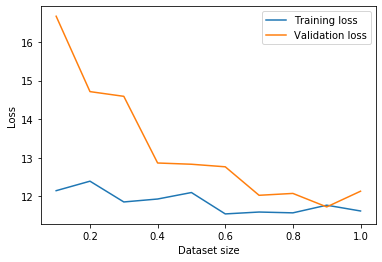

In [25]:
x = np.arange(0.1, 1.1, 0.1)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, val_loss, label='Validation loss')
plt.legend()
plt.xlabel("Dataset size")
plt.ylabel("Loss")
plt.show()

In [27]:
model.model.save('../Models/MLP_Regression_GroupBy_FFill_MinMax.h5')